In [1]:
import numpy as np
import scipy.stats as stats
from tqdm import tqdm as tqdm
import random
import pandas as pd
from scipy.optimize import bisect
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

## Что мы прошли на прошлых 4 занятиях

### Тесты для гипотезы сравнения средних 
- Параметрические тесты: 
    - z-тест
    - t-тест
- Непараметрические тесты:
    - Бутстрап
    
### Тесты для гипотез сравнения распределений
- Непараметрические тесты:
    - Колмогорова-Cмирнова 
    - Mанн-Уитни

--- 
### Синтетические АА-тесты для проверки валидности критерия
- на полностью синтетической модели данных
- на исторических данных 
    - независимые сегменты данных (например, разбиение по неделям и гео)
    - шаффлинг одного и того же датасета (проблема: зависимость выборок)

### Синтетические АB-тесты для проверки качества критерия
- при условии валидности критерия сравниваем мощности 

### Метрики отношения
- Дельта-метод оценки дисперсии
- Линеаризация
- Бакетизация
- Бутстрап

### Доверительные интервалы 
- Для дельты value и ratio
- Для uplift value и ratio
- Одновыборочный критерий для персентилей (по пользователям, по событиям)
- Бутстрапированные доверительные интервалы 


### Методы повышения чувствительности 
- Работа с выборосами 
- Cuped

In [2]:
def proportion_ci(pvalue_vector, alpha=0.05):
    pvalue_vector = np.asarray(pvalue_vector).flatten()
    n = len(pvalue_vector)
    count = np.sum(pvalue_vector < alpha)
    p = count / n
    left_bound = p - np.sqrt(p * (1 - p) / n) * stats.norm.ppf(1-alpha/2)
    right_bound = p + np.sqrt(p * (1 - p) / n) * stats.norm.ppf(1-alpha/2)
    return p, left_bound, right_bound

def plot_comparison_with_uniform(p_value_vector, title, color='skyblue', is_effect = False):
    # Предполагаем, что функция proportion_ci определена отдельно
    p, left_boundary, right_boundary = proportion_ci(p_value_vector)
    if is_effect == False:
        print(f"Ошибка I рода: {round(p, 4)},\nCI для oшибки I рода: [{round(left_boundary, 4)}, {round(right_boundary, 4)}]")
    else: 
        print(f"Мощность: {round(p, 4)},\nCI для мощности: [{round(left_boundary, 4)}, {round(right_boundary, 4)}]")

    fig1, ax1 = plt.subplots(1, 3, figsize=(17, 5))
    
    # --- 1. Гистограмма P-value ---
    ax1[0].hist(p_value_vector, bins=30, edgecolor='black', alpha=0.7, color=color)
    if is_effect == False:
        ax1[0].set_title(
        f'Ошибка I рода: {round(np.sum(np.array(p_value_vector) < 0.05) / len(p_value_vector), 3)}'
        )
    else: 
        ax1[0].set_title(
        f'Мощность: {round(np.sum(np.array(p_value_vector) < 0.05) / len(p_value_vector), 3)}'
        )
    ax1[0].set_xlabel('P-value')
    ax1[0].set_ylabel('Частота')
    
    # --- 2. QQ-график ---
    stats.probplot(p_value_vector, dist=stats.uniform, plot=ax1[1])
    ax1[1].get_lines()[1].set_linestyle('--')
    ax1[1].set_title(f'{title} (QQ-график)')
    
    # --- 3. Эмпирическая функция распределения ---
    pvals_sorted = np.sort(p_value_vector)
    n = len(pvals_sorted)
    ecdf = np.arange(1, n+1) / n

    x_uniform = np.linspace(0, 1, 200)
    cdf_uniform = x_uniform

    ax1[2].step(pvals_sorted, ecdf, where='post', label='Эмпирическая ФР', color=color)
    ax1[2].plot(x_uniform, cdf_uniform, 'k--', label='Теоретическая CDF $U[0,1]$')
    
    # --- Тест Колмогорова-Смирнова ---
    ks_statistic, ks_p_value = stats.kstest(p_value_vector, 'uniform', args=(0, 1))
    print(f'Статистика Колмогорова-Смирнова: {round(ks_statistic, 4)}, pvalue для сравнения ЭФР с равномерным: {round(ks_p_value, 4)}')
    if ks_p_value < 0.05:
        print("Гипотеза H0 отвергается: выборка НЕ из равномерного U(0,1)")
    else:
        print("Нет оснований отвергнуть H0: выборка МОГЛА быть из U(0,1)")
    
    ax1[2].set_title('Эмпирическая и теоретическая ФР')
    ax1[2].set_xlabel('p-value')
    ax1[2].set_ylabel('F(p-value)')
    ax1[2].legend(loc="lower right")
    ax1[2].text(
        0.05, 0.9,
        f"KS: stat={ks_statistic:.3f}\np={ks_p_value:.3f}",
        transform=ax1[2].transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle="round", fc="w", alpha=0.5)
    )

    plt.tight_layout()
    plt.show()

## 1.1 Стратификация

[Оригинальная статья](https://docs.yandex.ru/docs/view?tm=1749411883&tld=ru&lang=en&name=2013-02-CUPED-ImprovingSensitivityOfControlledExperiments.pdf&text=сuped%20Controlled%20Pre-experiment%20Data%20deng%20microsoft&url=https%3A%2F%2Fexp-platform.com%2FDocuments%2F2013-02-CUPED-ImprovingSensitivityOfControlledExperiments.pdf&lr=103817&mime=pdf&l10n=ru&sign=29a509e67d6f16e592323500921833ef&keyno=0&nosw=1&serpParams=tm%3D1749411883%26tld%3Dru%26lang%3Den%26name%3D2013-02-CUPED-ImprovingSensitivityOfControlledExperiments.pdf%26text%3D%25D1%2581uped%2BControlled%2BPre-experiment%2BData%2Bdeng%2Bmicrosoft%26url%3Dhttps%253A%2F%2Fexp-platform.com%2FDocuments%2F2013-02-CUPED-ImprovingSensitivityOfControlledExperiments.pdf%26lr%3D103817%26mime%3Dpdf%26l10n%3Dru%26sign%3D29a509e67d6f16e592323500921833ef%26keyno%3D0%26nosw%3D1)

[Хорошая статья на Хабр](https://habr.com/ru/companies/X5Tech/articles/596279/)


**Что такое стратификация? (stratification)**
Это когда вы заранее делите всеx ваших пользователей на страты (группы) по какому-то признаку (например, «город», «новичковость», «основной тариф»...), а потом внутри каждой страты тянете случайную подвыборку для эксперимента.

Две страты: пользователи, которые заказывают такси через приложение, пользователи, которые заказывают такси по телефону. 

Две страты: пользователи IOS, пользователи Android

Пять страт:  'менее 200 тыс.', 'от 200 тыс. до 1 млн.', 'от 1 млн.', 'Москва', 'Санкт-Петербург' 

<img src="pictures/strats.png" width="800">


### Функция стратифицированного семплирования


In [3]:
def strict_strat_sampling(strata_params, strata_props, n_total, effect = 0, random_state=None):
    '''
    Возвращает: контроль и тест с нужными пропорциями и нормальным распределением в каждой страте.
    '''
    np.random.seed(random_state)
    dfs_control = []
    dfs_test = []
    for stratum, prop in strata_props.items():
        n_control = int(n_total * prop)
        n_test = int(n_total * prop)
        mu = strata_params[stratum]['mu']
        sigma = strata_params[stratum]['sigma']
        if n_control > 0:
            vals_c = np.random.normal(loc=mu, scale=sigma, size=n_control)
            dfs_control.append(pd.DataFrame({'stratum': stratum, 'check': vals_c}))
        if n_test > 0:
            vals_t = np.random.normal(loc=mu, scale=sigma, size=n_test)*(1+effect)
            dfs_test.append(pd.DataFrame({'stratum': stratum, 'check': vals_t}))
    control = pd.concat(dfs_control).reset_index(drop=True)
    test = pd.concat(dfs_test).reset_index(drop=True)
    return control, test




### Функция случайного семплирования


In [4]:
def random_strat_sampling(strata_params, strata_props, n_total, effect = 0, random_state=None):
    '''
    Для каждого участника случайная страта по пропорциям, а чек — из соответствующего нормального распределения.
    '''
    np.random.seed(random_state)
    strata = list(strata_props.keys())
    props = np.array(list(strata_props.values()))
    # Для контроля
    chosen_control = np.random.choice(strata, size=n_total, p=props)
    vals_c = [np.random.normal(loc=strata_params[s]['mu'], scale=strata_params[s]['sigma']) for s in chosen_control]
    # Для теста
    chosen_test = np.random.choice(strata, size=n_total, p=props)
    vals_t = [np.random.normal(loc=strata_params[s]['mu'], scale=strata_params[s]['sigma'])*(1+effect) for s in chosen_test]
    control = pd.DataFrame({'stratum': chosen_control, 'check': vals_c})
    test = pd.DataFrame({'stratum': chosen_test, 'check': vals_t})
    return control, test



In [5]:
strata_props = {'Москва': 0.7, 'Малый регион': 0.3}
strata_params = {
    'Москва': {'mu': 500, 'sigma': 150},
    'Малый регион': {'mu': 350, 'sigma': 70},
}
n_total = 500


# Стратифицированное
control_strat, test_strat = strict_strat_sampling(
    strata_params, strata_props, n_total, random_state=42
)
print("Стратифицированное:")
print(control_strat['stratum'].value_counts(normalize=True))
print(test_strat['stratum'].value_counts(normalize=True))

# Случайное
control_rand, test_rand = random_strat_sampling(
    strata_params, strata_props, n_total, random_state=99
)
print("\nСлучайное:")
print(control_rand['stratum'].value_counts(normalize=True))
print(test_rand['stratum'].value_counts(normalize=True))


Стратифицированное:
stratum
Москва          0.7
Малый регион    0.3
Name: proportion, dtype: float64
stratum
Москва          0.7
Малый регион    0.3
Name: proportion, dtype: float64

Случайное:
stratum
Москва          0.674
Малый регион    0.326
Name: proportion, dtype: float64
stratum
Москва          0.694
Малый регион    0.306
Name: proportion, dtype: float64


In [6]:
control_rand

,stratum,check
0,Москва,781.937032
1,Москва,612.907657
2,Малый регион,327.049619
3,Москва,580.510864
4,Малый регион,309.543279
...,...,...
495,Малый регион,430.749808
496,Москва,375.233591
497,Малый регион,268.370130
498,Москва,348.036572


In [7]:
pvalue_tt_vec = []
pvalue_strat_vec = []
delta_rand = []
delta_strat = []
for i in tqdm(range(10000)):
    control_strat, test_strat = strict_strat_sampling(strata_params, strata_props, n_total = 1000)
    control_rand, test_rand = random_strat_sampling(strata_params, strata_props, n_total = 1000)
    d_rand = np.mean(test_rand['check'].tolist()) - np.mean(control_rand['check'].tolist())
    delta_rand.append(d_rand)
    d_strat = np.mean(test_strat['check'].tolist()) - np.mean(control_strat['check'].tolist())
    delta_strat.append(d_strat)
    _, pvalue_tt = stats.ttest_ind(test_rand['check'].tolist(), control_rand['check'].tolist(), equal_var=False)
    _, pvalue_strat = stats.ttest_ind(test_strat['check'].tolist(), control_strat['check'].tolist(), equal_var=False)
    pvalue_tt_vec.append(pvalue_tt)
    pvalue_strat_vec.append(pvalue_strat)

100%|██████████| 10000/10000 [02:30<00:00, 66.33it/s]


Ошибка I рода: 0.0497,
CI для oшибки I рода: [0.0454, 0.054]
Статистика Колмогорова-Смирнова: 0.0065, pvalue для сравнения ЭФР с равномерным: 0.7835
Нет оснований отвергнуть H0: выборка МОГЛА быть из U(0,1)


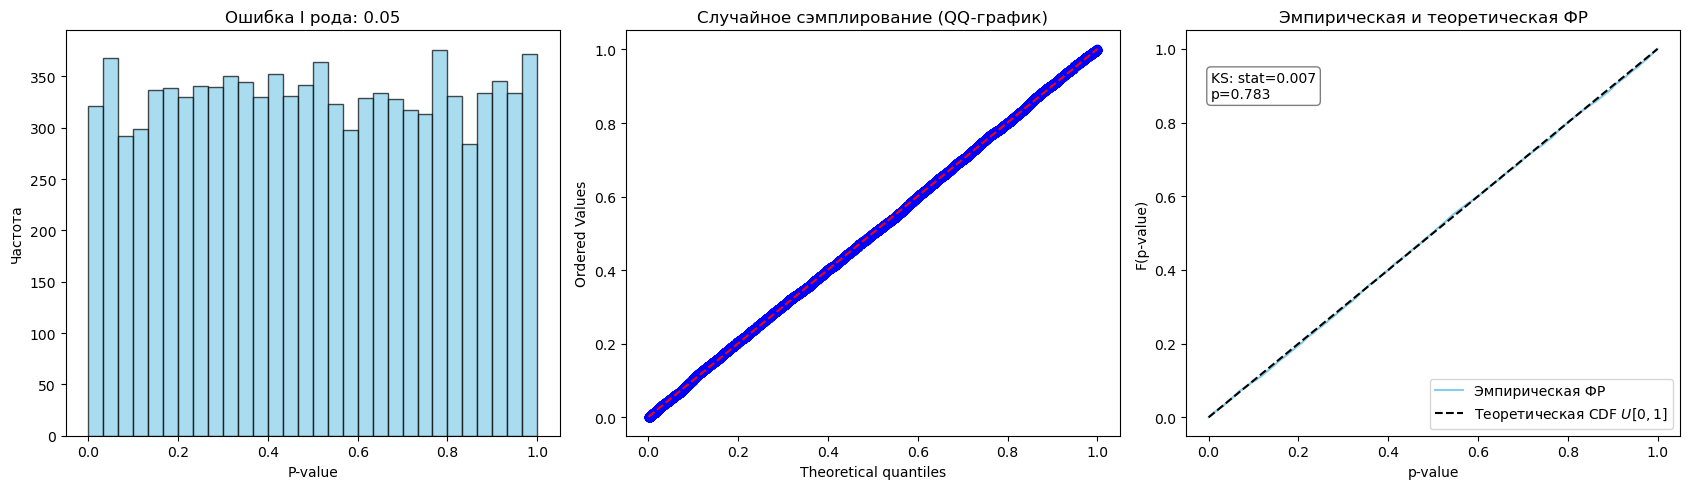

In [8]:
plot_comparison_with_uniform(pvalue_tt_vec, 'Случайное сэмплирование')

Ошибка I рода: 0.0291,
CI для oшибки I рода: [0.0258, 0.0324]
Статистика Колмогорова-Смирнова: 0.059, pvalue для сравнения ЭФР с равномерным: 0.0
Гипотеза H0 отвергается: выборка НЕ из равномерного U(0,1)


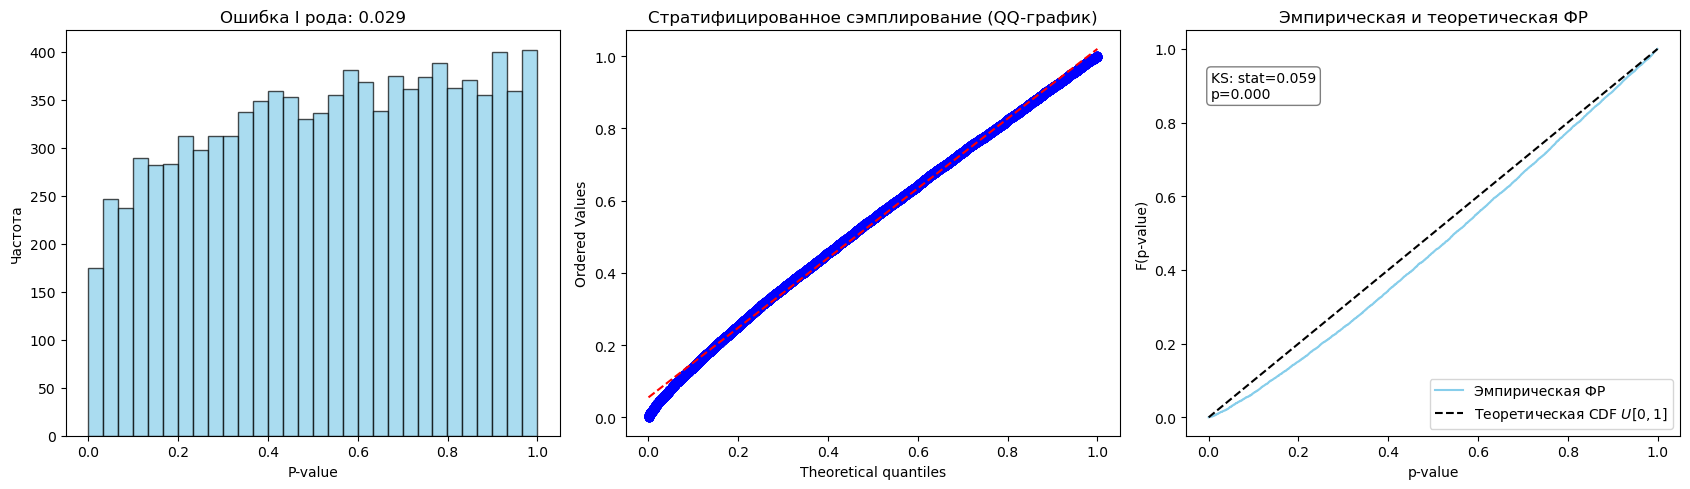

In [9]:
plot_comparison_with_uniform(pvalue_strat_vec, 'Стратифицированное сэмплирование')

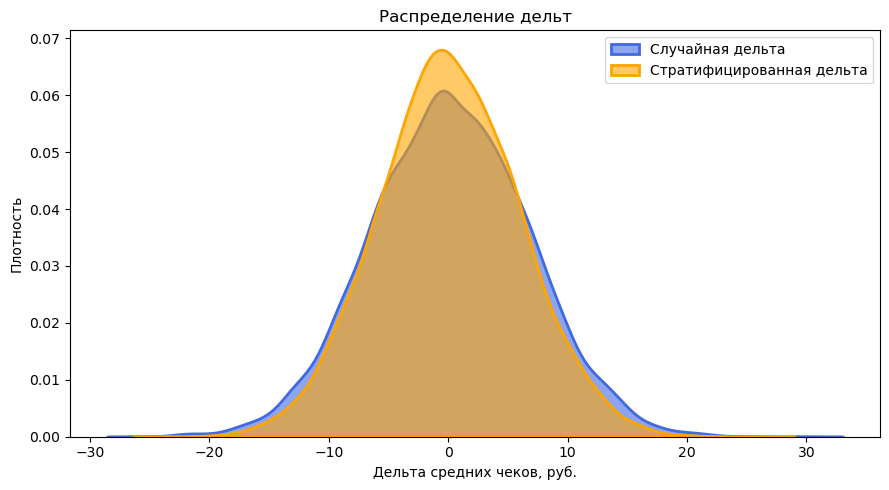

In [10]:
plt.figure(figsize=(9, 5))

# KDE (плотность)
sns.kdeplot(delta_rand, fill=True, color='royalblue', label='Случайная дельта', linewidth=2, alpha=0.6)
sns.kdeplot(delta_strat, fill=True, color='orange', label='Стратифицированная дельта', linewidth=2, alpha=0.6)

plt.xlabel("Дельта средних чеков, руб.")
plt.ylabel("Плотность")
plt.title("Распределение дельт")
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
np.var(delta_rand, ddof = 1)

np.float64(43.80676111393728)

In [12]:
np.var(delta_strat, ddof = 1)

np.float64(34.986507977738924)

In [13]:
effect = 0.03
pvalue_tt_eff_vec = []
pvalue_strat_eff_vec = []
delta_eff_rand = []
delta_eff_strat = []
for i in tqdm(range(1000)):
    control_strat, test_strat = strict_strat_sampling(strata_params, strata_props, n_total = 300, effect = effect)
    control_rand, test_rand = random_strat_sampling(strata_params, strata_props, n_total = 300, effect = effect)
    d_rand = np.mean(test_rand['check'].tolist()) - np.mean(control_rand['check'].tolist())
    delta_eff_rand.append(d_rand)
    d_strat = np.mean(test_strat['check'].tolist()) - np.mean(control_strat['check'].tolist())
    delta_eff_strat.append(d_strat)
    _, pvalue_tt = stats.ttest_ind(test_rand['check'].tolist(), control_rand['check'].tolist(), equal_var=False)
    _, pvalue_strat = stats.ttest_ind(test_strat['check'].tolist(), control_strat['check'].tolist(), equal_var=False)
    pvalue_tt_eff_vec.append(pvalue_tt)
    pvalue_strat_eff_vec.append(pvalue_strat)

100%|██████████| 1000/1000 [00:09<00:00, 102.86it/s]


Мощность: 0.192,
CI для мощности: [0.1676, 0.2164]
Статистика Колмогорова-Смирнова: 0.2502, pvalue для сравнения ЭФР с равномерным: 0.0
Гипотеза H0 отвергается: выборка НЕ из равномерного U(0,1)


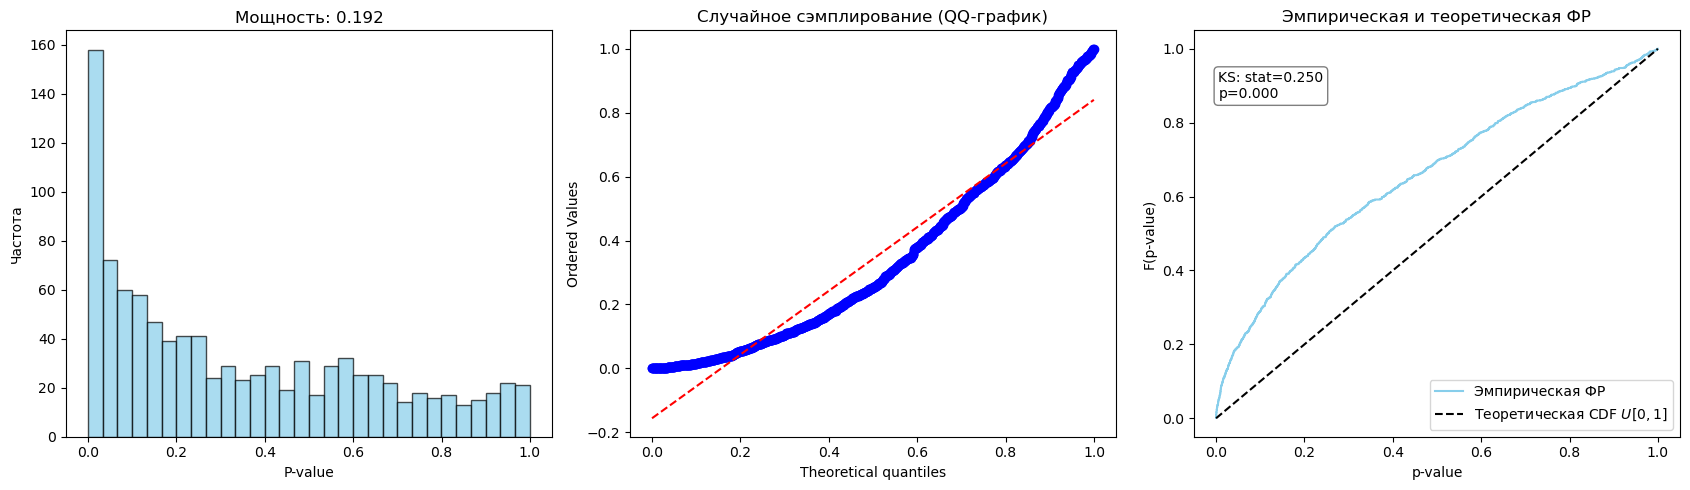

In [14]:
plot_comparison_with_uniform(pvalue_tt_eff_vec, 'Случайное сэмплирование', is_effect = True)

Мощность: 0.182,
CI для мощности: [0.1581, 0.2059]
Статистика Колмогорова-Смирнова: 0.2695, pvalue для сравнения ЭФР с равномерным: 0.0
Гипотеза H0 отвергается: выборка НЕ из равномерного U(0,1)


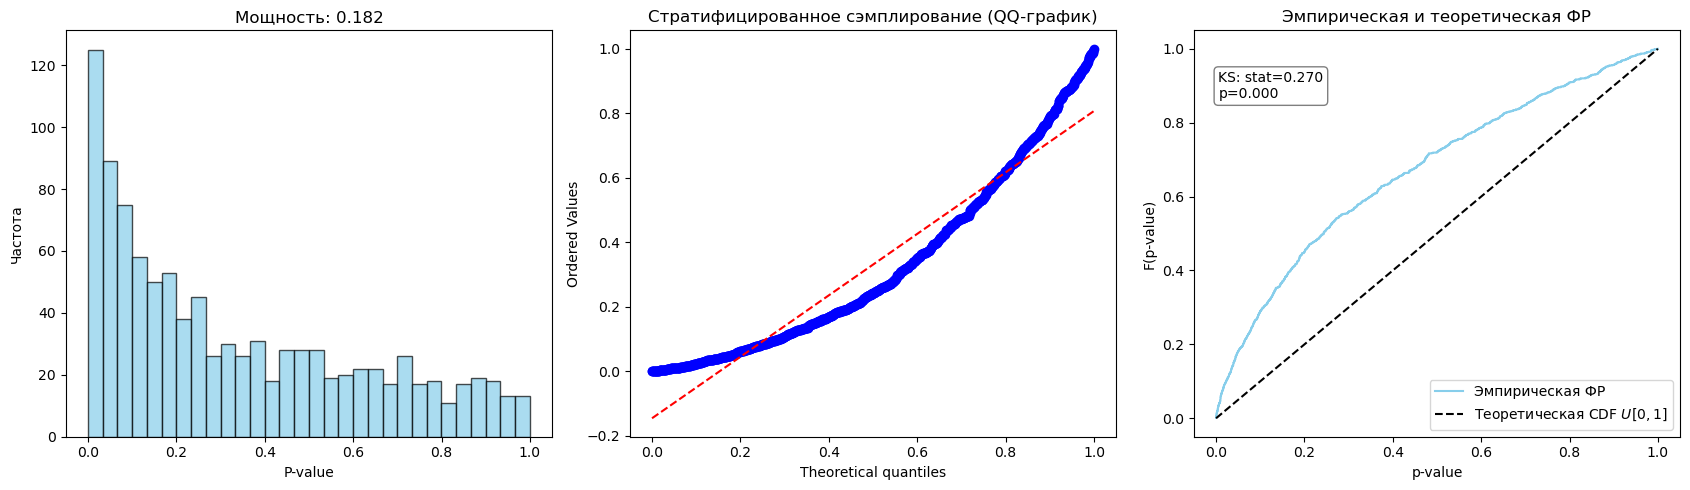

In [15]:
plot_comparison_with_uniform(pvalue_strat_eff_vec, 'Стратифицированное сэмплирование', is_effect = True)

In [16]:
good_cnt_tt = []
good_cnt_strat = []
for n in [25, 50, 100, 250, 500, 750, 1000, 1500, 2000, 5000]:
    cnt_tt = 0
    cnt_strat = 0
    for i in tqdm(range(1000)):
        control_strat, test_strat = strict_strat_sampling(strata_params, strata_props, n_total = n, effect = effect)
        control_rand, test_rand = random_strat_sampling(strata_params, strata_props, n_total = n, effect = effect)
        _, pvalue_tt = stats.ttest_ind(test_rand['check'].tolist(), control_rand['check'].tolist(), equal_var=False)
        _, pvalue_strat = stats.ttest_ind(test_strat['check'].tolist(), control_strat['check'].tolist(), equal_var=False)
        if pvalue_tt < 0.05:
            cnt_tt += 1
        if pvalue_strat < 0.05:
            cnt_strat += 1
    good_cnt_tt.append(cnt_tt/1000)
    good_cnt_strat.append(cnt_strat/1000)

100%|██████████| 1000/1000 [00:35<00:00, 28.16it/s]


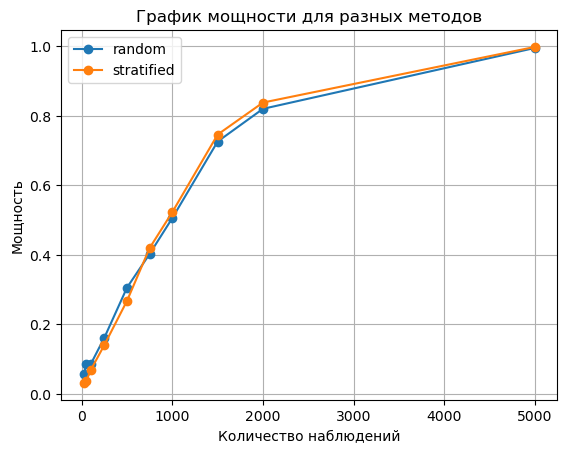

In [17]:
n = [25, 50, 100, 250, 500, 750, 1000, 1500, 2000, 5000]

plt.plot(n, good_cnt_tt, marker='o', label='random')
plt.plot(n, good_cnt_strat, marker='o', label='stratified')

plt.xlabel('Количество наблюдений')
plt.ylabel('Мощность')
plt.title('График мощности для разных методов')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
n = [25, 50, 100, 250, 500, 750, 1000, 1500, 2000, 5000]

df = pd.DataFrame({
    'rand': good_cnt_tt,
    'strat': good_cnt_strat

}, index=n)

df.index.name = 'n'
print(df)

       rand  strat
n                 
25    0.057  0.032
50    0.085  0.038
100   0.086  0.069
250   0.162  0.141
500   0.306  0.268
750   0.403  0.420
1000  0.506  0.523
1500  0.726  0.746
2000  0.820  0.838
5000  0.995  0.998


### Стратифицированное среднее

**Обычное среднее (Sample Mean)**
$$
\bar{X} = \dfrac{1}{n} \sum\limits_{i=1}^n X_i
$$

**Стратифицированное среднее (с определением среднего по страте)**

$$
\bar{X}_{\text{strat}} = \sum_{k=1}^{K} w_k\, \bar{X}_k
$$
где
$
\bar{X}_k = \dfrac{1}{n_k} \sum\limits_{i \in S_k} X_i,
$

$K$ количество страт, $w_k$ - доля  $k$-й страты в популяции,

$n_k$ — число наблюдений в $k$-й страте, $S_k$ — множество индексов объектов $k$-й страты.

**При стратифицированном семплировании  выборочное стратифицированного среднего равно обычному выборочному среднему**


Пусть всего $n$ объектов в выборке, всего $K$ страт.

В страте $k$ выбрано $n_k$ объектов, $\sum_{k=1}^K n_k = n$.

$w_k = \frac{n_k}{n}$ — доля $k$-й страты в выборке.

$X_i$ — значение наблюдения $i$ ($i = 1, \dots, n$).

$S_k$ — множество индексов объектов $k$-й страты.

**Обычное (выборочное) среднее:**
$$
\overline{X} = \frac{1}{n} \sum_{i=1}^{n} X_i
$$

**Стратифицированное среднее:**
$$
\overline{X}_{\text{strat}} = \sum_{k=1}^{K} w_k\, \overline{X}_k
$$
где
$$
\overline{X}_k = \frac{1}{n_k} \sum_{i \in S_k} X_i,\qquad w_k = \frac{n_k}{n}
$$



Подставим выражение для $\overline{X}_k$ и $w_k$:
$$
\overline{X}_{\text{strat}} = \sum_{k=1}^{K} \frac{n_k}{n} \left( \frac{1}{n_k} \sum_{i \in S_k} X_i \right )
= \frac{1}{n} \sum_{k=1}^{K} \sum_{i \in S_k} X_i
$$

Но $\bigcup_{k=1}^{K} S_k$ — это все индексы выборки, значит,
$$
\sum_{k=1}^{K} \sum_{i \in S_k} X_i = \sum_{i=1}^n X_i
$$

Поэтому
$$
\overline{X}_{\text{strat}} = \frac{1}{n} \sum_{i=1}^n X_i = \overline{X}
$$


$$
\boxed{
\overline{X}_{\text{strat}} = \overline{X}
}
$$


### Дисперсия стратифицированного среднего 
при стратифицированном сэмплировании 

$$
\mathrm{Var}(\overline{X}_{\text{strat}})
= \sum_{k=1}^{K} w_k^2\, \frac{\sigma_k^2}{n_k}
$$

где

$$
w_k = \frac{n_k}{n}
$$

$$
\sigma_k^2 = \text{дисперсия внутри } k\text{-й страты}
$$

$$
n = \sum_{k=1}^{K} n_k
$$

$$
n_k = \text{размер выборки из } k\text{-й страты}
$$



$$
\mathrm{Var}(\overline{X}_{\text{strat}})
= \sum_{k=1}^{K} w_k\, \frac{n_k}{n} \frac{\sigma_k^2}{n_k} = \frac{1}{n}\sum_{k=1}^{K} w_k\,\sigma_k^2
$$

### Научимся считать стратифицированное среднее и стратифицированную дисперсию

In [19]:
def stratified_mean(df, strata_props):
    means = df.groupby('stratum')['check'].mean()
    return sum(strata_props[k] * means[k] for k in means.index)

def stratified_variance(df, strata_props):
    var = df.groupby('stratum')['check'].var()
    return sum(strata_props[k] * var[k] for k in var.index)


In [20]:
def t_test_for_starts(strata_params, strata_props, n_total = 1000, effect = 0):
    control, test = strict_strat_sampling(strata_params, strata_props, n_total = n_total, effect = effect)
    
    delta_estimator = stratified_mean(test, strata_props) - stratified_mean(control, strata_props)
    sigma = np.sqrt(stratified_variance(test, strata_props)/n_total + stratified_variance(control, strata_props)/n_total)
    tt = delta_estimator/sigma
    p_value = 2*stats.t.sf(np.abs(tt),2*n_total-2)
    is_sign = 0
    if p_value < 0.05:
            is_sign = 1
    return is_sign, p_value

def t_test_for_random_starts(strata_params, strata_props, n_total = 1000, effect = 0):
    control, test = random_strat_sampling(strata_params, strata_props, n_total = n_total, effect = effect)
    
    delta_estimator = stratified_mean(test, strata_props) - stratified_mean(control, strata_props)
    sigma = np.sqrt(stratified_variance(test, strata_props)/n_total + stratified_variance(control, strata_props)/n_total)
    tt = delta_estimator/sigma
    p_value = 2*stats.t.sf(np.abs(tt),2*n_total-2)
    is_sign = 0
    if p_value < 0.05:
            is_sign = 1
    return is_sign, p_value
    

In [21]:
pvalue_strat_vec = []
for i in tqdm(range(10000)):
    _, pvalue_strat = t_test_for_starts(strata_params, strata_props, n_total = 1000, effect = 0)
    pvalue_strat_vec.append(pvalue_strat)

100%|██████████| 10000/10000 [00:41<00:00, 240.04it/s]


Ошибка I рода: 0.053,
CI для oшибки I рода: [0.0486, 0.0574]
Статистика Колмогорова-Смирнова: 0.0117, pvalue для сравнения ЭФР с равномерным: 0.1274
Нет оснований отвергнуть H0: выборка МОГЛА быть из U(0,1)


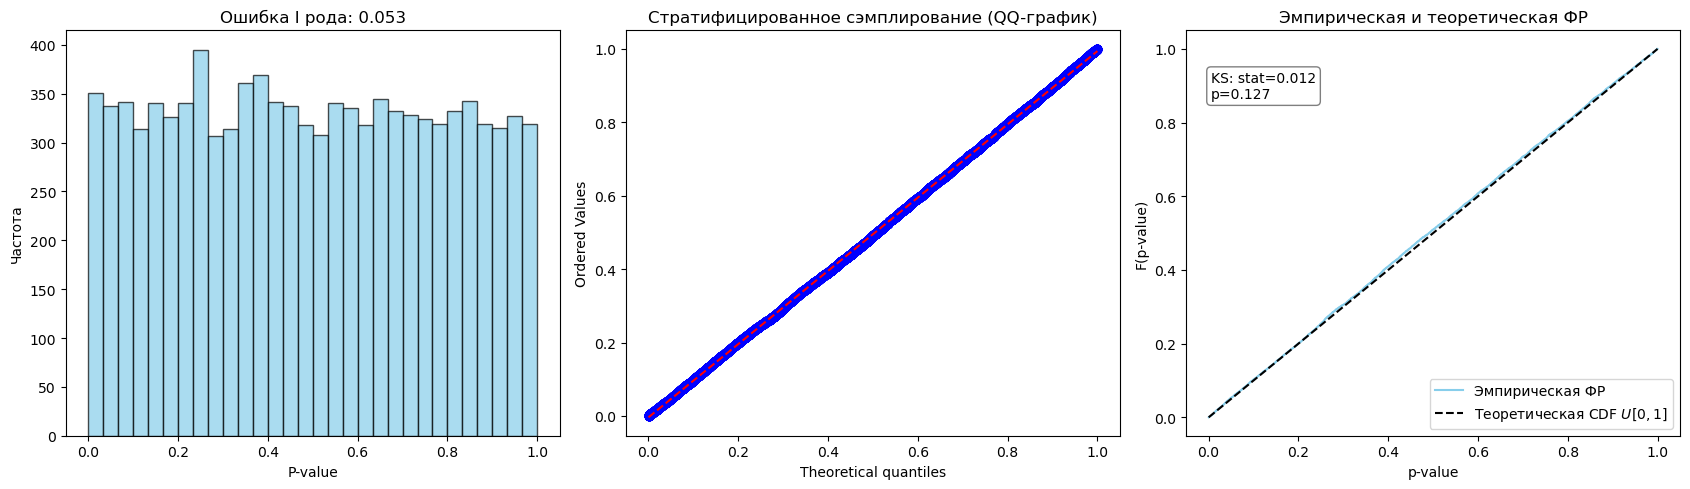

In [22]:
plot_comparison_with_uniform(pvalue_strat_vec, 'Стратифицированное сэмплирование')

In [23]:
effect = 0.03
good_cnt_tt = []
good_cnt_strat = []
for n in [25, 50, 100, 500, 1000, 2000, 5000, 10000]:
    cnt_tt = 0
    cnt_strat = 0
    for i in tqdm(range(1000)):
        control_rand, test_rand = random_strat_sampling(strata_params, strata_props, n_total = n, effect = effect)
        _, pvalue_tt = stats.ttest_ind(test_rand['check'].tolist(), control_rand['check'].tolist(), equal_var=False)
        _, pvalue_strat = t_test_for_starts(strata_params, strata_props, n_total = n, effect = effect)
        if pvalue_tt < 0.05:
            cnt_tt += 1
        if pvalue_strat < 0.05:
            cnt_strat += 1
    good_cnt_tt.append(cnt_tt/1000)
    good_cnt_strat.append(cnt_strat/1000)

100%|██████████| 1000/1000 [01:08<00:00, 14.56it/s]


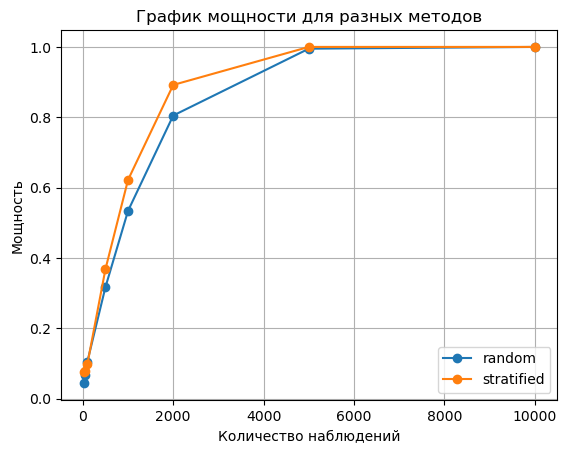

In [24]:
n = [25, 50, 100, 500, 1000, 2000, 5000, 10000]

plt.plot(n, good_cnt_tt, marker='o', label='random')
plt.plot(n, good_cnt_strat, marker='o', label='stratified')

plt.xlabel('Количество наблюдений')
plt.ylabel('Мощность')
plt.title('График мощности для разных методов')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
n = [25, 50, 100, 500, 1000, 2000, 5000, 10000]

df = pd.DataFrame({
    'rand': good_cnt_tt,
    'strat': good_cnt_strat

}, index=n)

df.index.name = 'n'
print(df)

        rand  strat
n                  
25     0.045  0.075
50     0.067  0.080
100    0.105  0.098
500    0.317  0.368
1000   0.534  0.622
2000   0.805  0.892
5000   0.995  1.000
10000  1.000  1.000


## 2. Постстрафикация

Случайное сэмплирование, но при этом стратифицированное среднее и дисперсия.

**Закон полной дисперсии** (или разложение дисперсии по формуле полной дисперсии, англ. “law of total variance”) — позволяет выразить дисперсию случайной величины через условные (внутри подгрупп) моменты относительно некоторой классификации (группировочной переменной, например, страты).

---

Если есть случайные величины $X$ и $Y$, то закон полной дисперсии гласит:
$
\mathrm{Var}(X) = \mathbb{E}\Big[ \mathrm{Var}(X\,|\,Y) \Big] + \mathrm{Var}\Big( \mathbb{E}[X\,|\,Y] \Big)
$

- $\mathbb{E}[\mathrm{Var}(X|Y)] $ - **внутригрупповой разброс:** средняя условная дисперсия $ X $ при фиксированных $ Y $ или  
- $ \mathrm{Var}(\mathbb{E}[X|Y])$ - **межгрупповой разброс:**  
  насколько отличаются между собой средние значений  $ X $ в разных группах $ Y $.

**Сумма этих двух величин и есть полная (общая) дисперсия.**

---

$$
\text{Var}(\overline{X}_{strat}) = \mathbb{E}\left[\text{Var}(\bar{X}_{strat} \mid n_1,\ldots,n_K)\right] + \text{Var}\left(\mathbb{E}(\bar{X}_{strat} \mid n_1,\ldots,n_K)\right)
$$

$\mathbb{E}\left[\text{Var}(\bar{X}_{strat} \mid n_1,\ldots,n_K)\right]$:

---

1. Стратифицированное среднее:  

$
\bar{X}_{strat} = \sum_{k=1}^{K} w_k \bar{X}_k
$

где $\bar{X}_k $ — среднее по страти $k$, а $w_k$ — вес (доля) страты.

---

2. Дисперсия (при фиксированном $n_k$):$\text{Var}\left(\bar{X}_{strat} \mid n_1,...,n_K \right)$

Так как при фиксированном $n_k$ среднее по независимым наблюдениям из страты $k$ дисперсия как для среднего:

$
\text{Var}(\bar{X}_k \mid n_k) = \dfrac{\sigma_k^2}{n_k}
$

Подставляем:
$
\text{Var}(\bar{X}_{strat}\mid n_1,...,n_K ) = \sum_{k=1}^{K}w_k^2 \dfrac{\sigma_k^2}{n_k}
$

---

3. Берём математическое ожидание по всем возможным $n_k$:

$
\mathbb{E}\left[\sum_{k=1}^{K} w_k^2 \frac{\sigma_k^2}{n_k}\right]
= \sum_{k=1}^{K} w_k^2 \sigma_k^2 \mathbb{E}\left( \dfrac{1}{n_k} \right)
$

Найдем $\mathbb{E}\left(\dfrac{1}{n_k}\right)$.

$n_k$ — **случайная** величина, распределённая как биномиальная $Bin(n, w_k)$.

Используем разложение по формуле Тейлора функции $f(x) = 1/x$ в окрестности её мат. ожидания $\mathbb{E}[n_k] = n w_k$:

$
f(n_k) \approx f(n w_k) + f'(n w_k) (n_k - n w_k) + \dfrac{f''(n w_k)}{2} (n_k - n w_k)^2
$

- $f(n_k) = \dfrac{1}{n_k}, f(n w_k) = \dfrac{1}{n w_k}$
- $f'(x) = -\dfrac{1}{x^2}, f''(x) = 2/x^3$

Оставляем члены до второго порядка (дисперсионно-центрированное приближение):

$
\dfrac{1}{n_k} \approx \dfrac{1}{n w_k} - \dfrac{1}{(n w_k)^2}(n_k - n w_k) + \dfrac{1}{(n w_k)^3}(n_k - n w_k)^2
$

Берём ожидание по случайной выборке:

1. $\mathbb{E}(n_k - n w_k) = 0$ (среднее биномиального смещения — ноль)
2. $\mathbb{E}\left((n_k - n w_k)^2\right) = \mathrm{Var}(n_k) = n w_k (1 - w_k)$ (дисперсия биномиального)
3. Пренебрегаем членами более высокого порядка $(O(1/n^2)$).

Подставляем:

$
\mathbb{E}\left( \dfrac{1}{n_k} \right) \approx \dfrac{1}{n w_k} + \dfrac{1}{(n w_k)^3} n w_k (1-w_k)
= \dfrac{1}{n w_k} + \dfrac{1-w_k}{n^2 w_k^2}
$

$
\mathbb{E}\left( \dfrac{1}{n_k} \right) = \dfrac{1}{n w_k} + \dfrac{1-w_k}{n^2 w_k^2} + O\left(\dfrac{1}{n^2}\right)
$

---

4. Вторая часть — дисперсия мат. ожидания:$
\text{Var}\left(\mathbb{E}(\bar{X}_{strat} | n_1,...,n_K)\right)
$


$\mathbb{E}(\bar{X}_{strat} | n_1,...,n_K) = \mathbb{E}(\sum\limits_{k=1}^K w_k\bar{X}_k | n_1,...,n_K) = \sum\limits_{k=1}^K w_k\mu_k = \mu$

---

5. Итоговое выражение для стратифицированной дисперсии при случайном сэмплировании 

$
\text{Var}(\bar{X}_{strat}) = \sum_{k=1}^{K} w_k^2 \sigma_k^2 \mathbb{E}\left( \dfrac{1}{n_k} \right) = \dfrac{1}{n}\sum_{k=1}^{K} w_k \sigma_k^2 + \sum_{k=1}^{K} \dfrac{1-w_k}{n^2} \sigma_k^2 + O\left(\dfrac{1}{n^2}\right) = \dfrac{1}{n}\sum_{k=1}^{K} w_k \sigma_k^2 + O\left(\dfrac{1}{n^2}\right)
$



### Дисперсия при случайном сэмплировании выборочного среднего 


$
\sigma^2 = \dfrac{1}{N}\sum\limits_{k=1}^K \sum\limits_{i=1}^{N_k} (X_{ki} - \mu)^2
$

и заметить:

$
X_{ki} - \mu = (X_{ki} - \mu_k) + (\mu_k - \mu)
$

по формуле квадрата суммы:

$
(X_{ki} - \mu)^2 = (X_{ki} - \mu_k)^2 + 2(X_{ki} - \mu_k)(\mu_k - \mu) + (\mu_k - \mu)^2
$

Если просуммировать по всем $i,k$, то перекрестный член (сумма $(X_{ki} - \mu_k)$) даст ноль, так как среднее отклонение внутри страты — ноль.

Поэтому получится ровно та же формула:

$
\sigma^2 = \sum\limits_{k=1}^K w_k \sigma_k^2 + \sum\limits_{k=1}^K w_k (\mu_k - \mu)^2
$

$
\text{Var}\bar X = \dfrac{1}{n}\sum\limits_{k=1}^K w_k \sigma_k^2 + O\left(\dfrac{1}{n}\right)
$

---


In [26]:
pvalue_strat_vec = []
for i in tqdm(range(10000)):
    _, pvalue_strat = t_test_for_random_starts(strata_params, strata_props, n_total = 1000, effect = 0)
    pvalue_strat_vec.append(pvalue_strat)

100%|██████████| 10000/10000 [01:31<00:00, 109.16it/s]


Ошибка I рода: 0.0496,
CI для oшибки I рода: [0.0453, 0.0539]
Статистика Колмогорова-Смирнова: 0.0077, pvalue для сравнения ЭФР с равномерным: 0.5896
Нет оснований отвергнуть H0: выборка МОГЛА быть из U(0,1)


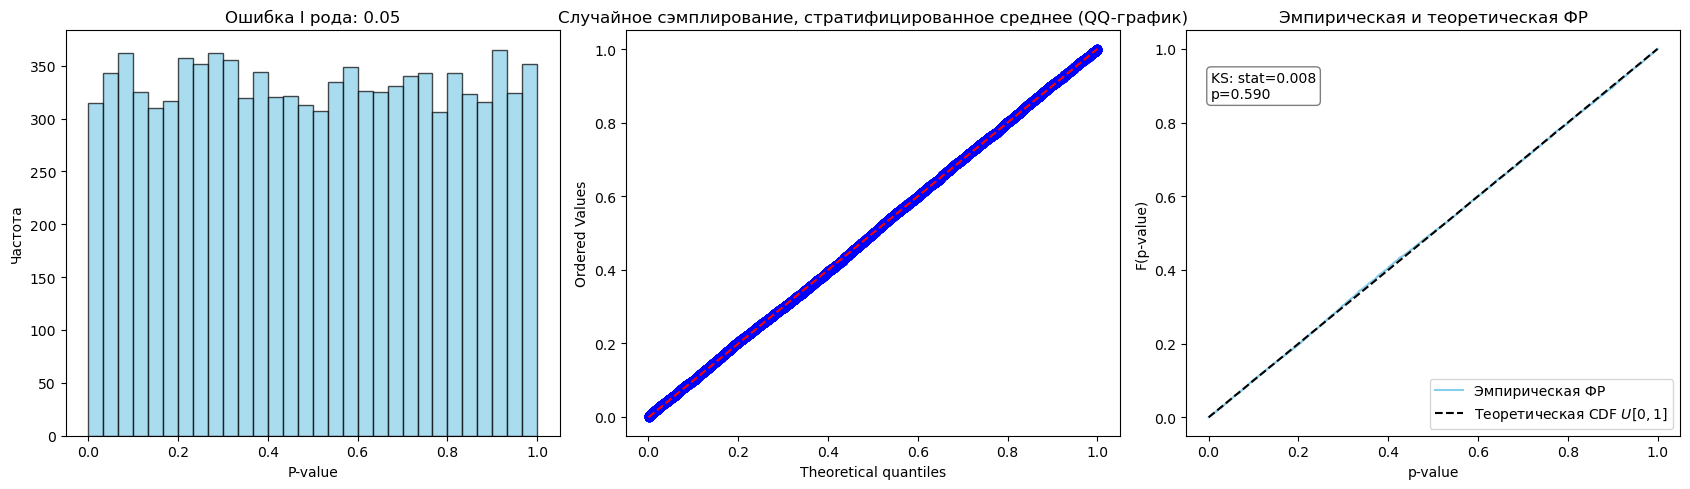

In [27]:
plot_comparison_with_uniform(pvalue_strat_vec, 'Случайное сэмплирование, стратифицированное среднее')

In [28]:
effect = 0.03
good_cnt_tt = []
good_cnt_strat = []
good_cnt_random_strat = []
for n in [25, 50, 100, 250, 500, 750, 1000, 1500, 2000, 5000]:
    cnt_tt = 0
    cnt_strat = 0
    cnt_random_strat = 0
    for i in tqdm(range(1000)):
        control_rand, test_rand = random_strat_sampling(strata_params, strata_props, n_total = n, effect = effect)
        _, pvalue_tt = stats.ttest_ind(test_rand['check'].tolist(), control_rand['check'].tolist(), equal_var=False)
        _, pvalue_strat = t_test_for_starts(strata_params, strata_props, n_total = n, effect = effect)
        _, pvalue_random_strat = t_test_for_random_starts(strata_params, strata_props, n_total = n, effect = effect)
        if pvalue_tt < 0.05:
            cnt_tt += 1
        if pvalue_strat < 0.05:
            cnt_strat += 1
        if pvalue_random_strat < 0.05:
            cnt_random_strat += 1
    good_cnt_tt.append(cnt_tt/1000)
    good_cnt_strat.append(cnt_strat/1000)
    good_cnt_random_strat.append(cnt_random_strat/1000)

100%|██████████| 1000/1000 [01:10<00:00, 14.15it/s]


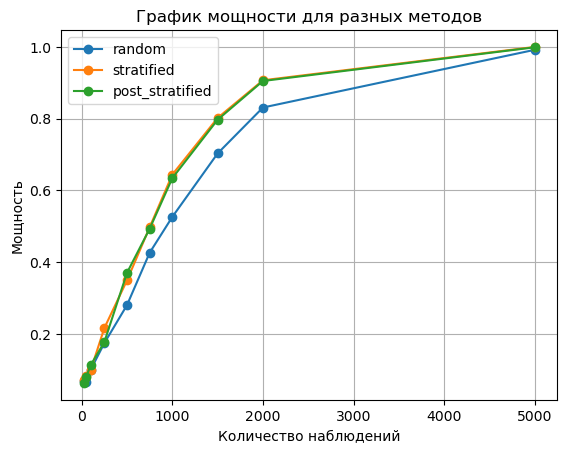

In [29]:
n = [25, 50, 100, 250, 500, 750, 1000, 1500, 2000, 5000]

plt.plot(n, good_cnt_tt, marker='o', label='random')
plt.plot(n, good_cnt_strat, marker='o', label='stratified')
plt.plot(n, good_cnt_random_strat, marker='o', label='post_stratified')

plt.xlabel('Количество наблюдений')
plt.ylabel('Мощность')
plt.title('График мощности для разных методов')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
n = [25, 50, 100, 250, 500, 750, 1000, 1500, 2000, 5000]

df = pd.DataFrame({
    'rand': good_cnt_tt,
    'strat': good_cnt_strat, 
    'post-strat': good_cnt_random_strat

}, index=n)

df.index.name = 'n'
print(df)

       rand  strat  post-strat
n                             
25    0.068  0.070       0.063
50    0.065  0.083       0.080
100   0.100  0.099       0.113
250   0.174  0.216       0.177
500   0.280  0.349       0.370
750   0.426  0.497       0.493
1000  0.526  0.644       0.634
1500  0.703  0.802       0.797
2000  0.831  0.907       0.905
5000  0.992  1.000       0.999


## 3. Проблема подглядывания

### p-value hacking

p-value hacking (или p-hacking) — это практика подгонки данных, методов анализа или проектирования эксперимента так, чтобы получить статистически значимые результаты (то есть p-value < 0.05), даже если на самом деле эффекта нет.

### Как оно работает?
Исследователь (часто не осознанно!) пробует разные методы анализа, фильтрацию данных, множество переменных, выбор подвыборок, проводит много повторных тестов без учёта множественности. Если делать много таких манипуляций, вполне можно "нащупать" статистически значимый результат случайно.

Примеры p-hacking:
- Многократное проведение тестов, но публикация только "успешных" (p < 0.05).
- Исследование разных разрезов данных до тех пор, пока не получится нужный результат.
- Исключение "неподходящих" наблюдений/групп задним числом.
- Множественные гипотезы — анализ до тех пор, пока какая-то не даст "значимый" результат.
- Остановка сбора данных "когда результат уже значим".

### Почему это опасно?
p-hacking сильно увеличивает вероятность ложноположительных результатов ("эффект найден случайно"), искажает картину науки и способствует не воспроизводимым исследованиям.

---

## 3.1 Подглядывание
---

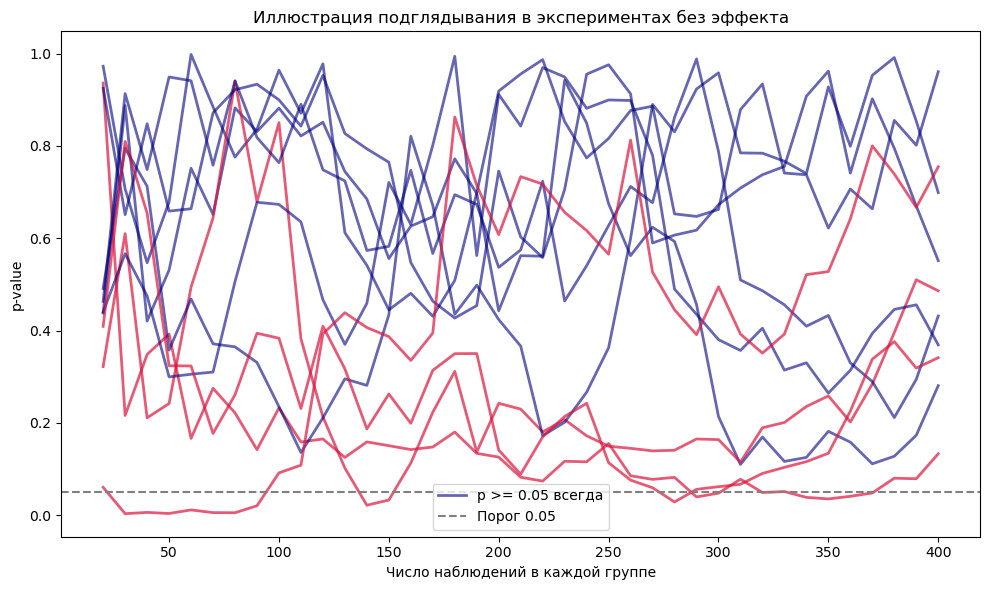

In [31]:
n_iters = 10       # Количество экспериментов
total_n = 400      # Финальный размер в группе
steps = np.arange(20, total_n+1, 10)  # Число точек во времени
pval_mat = []

for exp in range(n_iters):
    control = np.random.normal(0, 1, total_n)
    test    = np.random.normal(0, 1, total_n)  # Нет эффекта
    pvals = []
    for step in steps:
        _, p = ttest_ind(test[:step], control[:step], equal_var=False)
        pvals.append(p)
    pval_mat.append(pvals)
pval_mat = np.array(pval_mat)

# Для цвета: хотя бы один раз p < 0.05
mask_peeked = (pval_mat < 0.05).any(axis=1)

plt.figure(figsize=(10,6))
for idx in range(n_iters):
    if mask_peeked[idx]:
        plt.plot(steps, pval_mat[idx], color='crimson', lw=2, alpha=0.7, label='p < 0.05 (peeked)' if idx==0 else "")
    else:
        plt.plot(steps, pval_mat[idx], color='navy', lw=2, alpha=0.6, label='p >= 0.05 всегда' if idx==0 else "")
plt.axhline(0.05, ls='--', color='gray', label='Порог 0.05')
plt.xlabel("Число наблюдений в каждой группе")
plt.ylabel("p-value")
plt.title("Иллюстрация подглядывания в экспериментах без эффекта")
plt.legend()
plt.tight_layout()
plt.show()



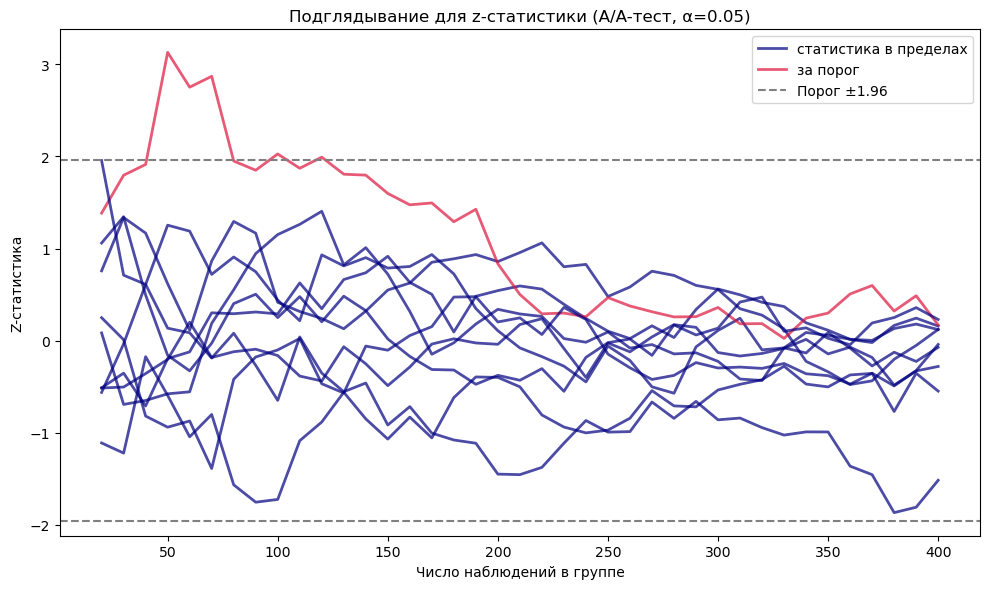

Доля ложных срабатываний: 10.00%


In [32]:
n_iters = 10
total_n = 400
steps = np.arange(20, total_n+1, 10)
alpha = 0.05
threshold = stats.norm.ppf(1 - alpha / 2)     # 1.96

z_mat = []

for exp in range(n_iters):
    control = np.random.normal(0, 1, total_n)
    test    = np.random.normal(0, 1, total_n)
    z_line = []
    for step in steps:
        mean_c = control[:step].mean()
        mean_t = test[:step].mean()
        std_c = control[:step].std(ddof=1)
        std_t = test[:step].std(ddof=1)
        z = (mean_t - mean_c) / np.sqrt(std_t**2/step + std_c**2/step)
        z_line.append(z)
    z_mat.append(z_line)
z_mat = np.array(z_mat)

# Сработали ли ложно хоть раз (ушли за границы)
thresholds = np.abs(z_mat) >= threshold
mask_peeked = thresholds.any(axis=1)

plt.figure(figsize=(10, 6))
for idx in range(n_iters):
    color = "crimson" if mask_peeked[idx] else "navy"
    label = "за порог" if (mask_peeked[idx] and idx == np.where(mask_peeked)[0][0]) else \
            "статистика в пределах" if (not mask_peeked[idx] and idx == np.where(~mask_peeked)[0][0]) else ""
    plt.plot(steps, z_mat[idx], color=color, alpha=0.7, lw=2, label=label)
plt.axhline(threshold, ls='--', color='gray', label=f"Порог ±{threshold:.2f}")
plt.axhline(-threshold, ls='--', color='gray')
plt.xlabel("Число наблюдений в группе")
plt.ylabel("Z-статистика")
plt.title(f"Подглядывание для z-статистики (A/A-тест, α={alpha})")
plt.legend()
plt.tight_layout()
plt.show()

print(f'Доля ложных срабатываний: {mask_peeked.mean():.2%}')


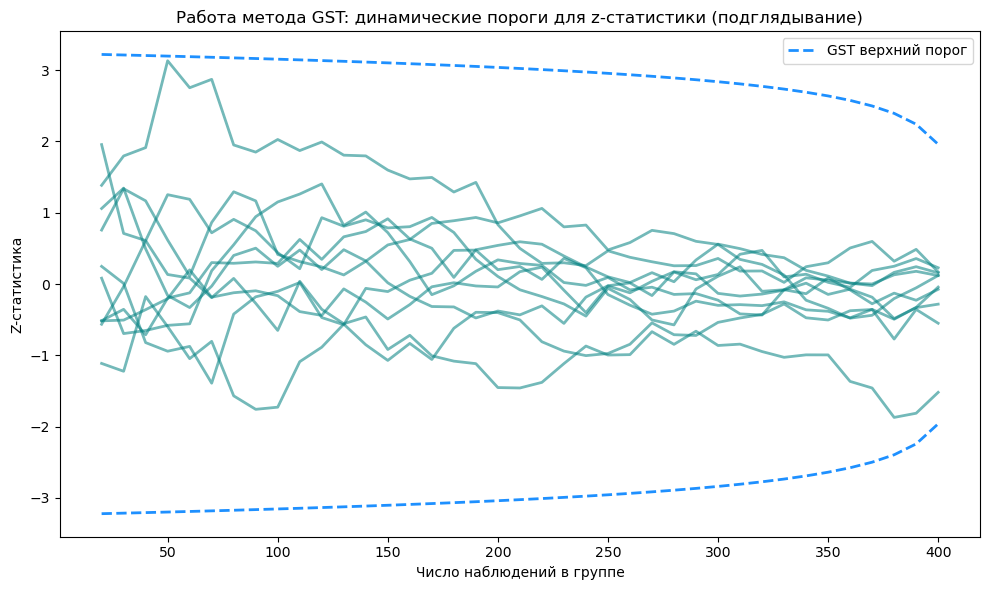

False positive rate для GST: 0.00%


In [33]:
plt.figure(figsize=(10, 6))
mask_gst = []

for idx in range(n_iters):
    this_z = z_mat[idx]
    s_peeked = False
    for i, step in enumerate(steps):
        # GST: threshold на step (Pocock ~постоянен, OBF сильно спадает, здесь пример с простой функцией)
        boundary = stats.norm.ppf(1 - alpha / (2 * (len(steps) - i)))
        if np.abs(this_z[i]) >= boundary:
            plt.plot(steps[:i+1], this_z[:i+1], color="orange", lw=2.5, alpha=0.6)
            s_peeked = True
            break
    if not s_peeked:
        plt.plot(steps, this_z, color="teal", lw=2, alpha=0.55)
    mask_gst.append(s_peeked)

# Нарисуем GST-порог на разных этапах
gst_thr = [stats.norm.ppf(1 - alpha / (2 * (len(steps) - i))) for i in range(len(steps))]
plt.plot(steps, gst_thr, ls='--', color='dodgerblue', lw=2, label='GST верхний порог')
plt.plot(steps, [-t for t in gst_thr], ls='--', color='dodgerblue', lw=2)

plt.xlabel("Число наблюдений в группе")
plt.ylabel("Z-статистика")
plt.title("Работа метода GST: динамические пороги для z-статистики (подглядывание)")
plt.legend()
plt.tight_layout()
plt.show()

print(f'False positive rate для GST: {np.mean(mask_gst):.2%}')


**GST (Group Sequential Test, групповой последовательный тест)** — это статистический подход, позволяющий многократно анализировать накопленные данные по мере их поступления (например, во время A/B-теста или клинического исследования), без увеличения совокупной вероятности ошибки I рода (“раздувания” FWER из-за подглядывания!).

### Bonferroni поправочная альфа

Если мы подглядываем $K$ раз, то 
$$\alpha/K$$


---

### O'Brien-Fleming (OBF) boundaries

- Очень жёстко "карательные" пороги на ранних этапах, к классическому значению (z=1.96) приближается только на финальном анализе.


Пусть у вас K промежуточных анализов (включая финальный). Для каждого анализа j (от 1 до K):

Z-граничное значение:  

$
Z_j = \Phi^{-1}\left(1 - \frac{\alpha}{2} / \sqrt{K/j}\right)
$


In [34]:
### O'Brien-Fleming

def obrien_fleming(K, alpha=0.05):
    # Вернёт массив границ для каждого анализа (двусторонний)
    bounds = []
    for k in range(1, K+1):
        prob = 1 - alpha / (2 * np.sqrt(K/k))
        bound = stats.norm.ppf(prob)
        bounds.append(bound)
    return np.array(bounds)


def bonferroni(K, alpha=0.05):
    # Попробуем подобрать границу численно
    z_star = stats.norm.ppf(1 - alpha/(2*K))   
    return np.array([z_star]*K)

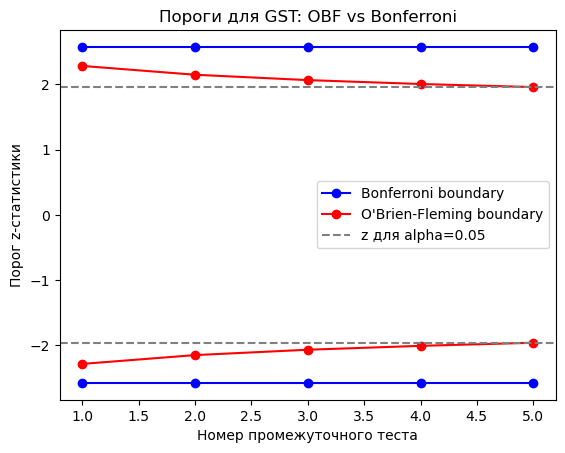

In [35]:

K = 5

obf_b = obrien_fleming(K)
bon_b = bonferroni(K)
color_bonf = 'blue'
color_obf = 'red'

plt.plot(range(1,K+1), bon_b, '-o', color=color_bonf, label='Bonferroni boundary')
plt.plot(range(1,K+1), -bon_b, '-o', color=color_bonf)
plt.plot(range(1,K+1), obf_b, '-o', color=color_obf, label="O'Brien-Fleming boundary")
plt.plot(range(1,K+1), -obf_b, '-o', color=color_obf)
plt.axhline(1.96, color='gray', linestyle='dashed', label='z для alpha=0.05')
plt.axhline(-1.96, color='gray', linestyle='dashed')
plt.xlabel('Номер промежуточного теста')
plt.ylabel('Порог z-статистики')
plt.title('Пороги для GST: OBF vs Bonferroni')
plt.legend()
plt.show()

### Когда считаем много критериев сразу 


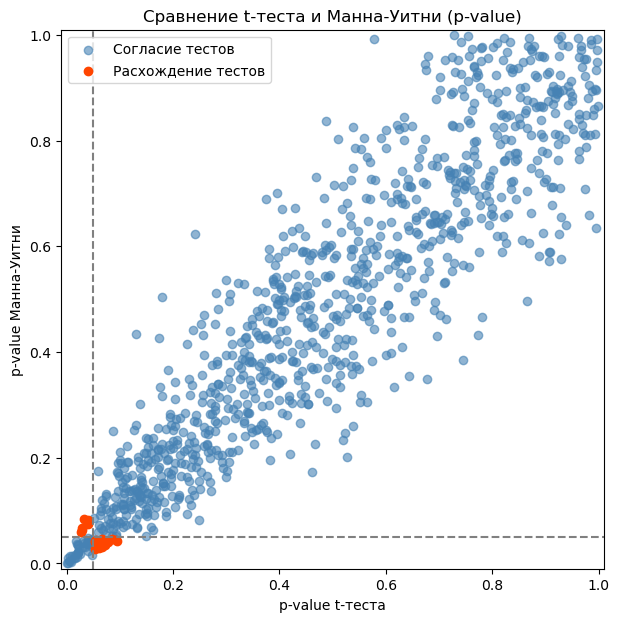

In [36]:
n_sim = 1000  # количество симуляций
nx, ny = 1000, 1000  # размер выборки
mu_x, mu_y = 0, 0.0  # эффект, разница в средних
sigma_x, sigma_y = 1, 1  # стандартное отклонение

pvals_t = []
pvals_mw = []

for _ in range(n_sim):
    x = np.random.normal(mu_x, sigma_x, nx)
    y = np.random.normal(mu_y, sigma_y, ny)
    # t-test (допускаем неравенство дисперсий)
    p_t = stats.ttest_ind(x, y, equal_var=False).pvalue
    p_mw = stats.mannwhitneyu(x, y, alternative='two-sided').pvalue

    pvals_t.append(p_t)
    pvals_mw.append(p_mw)

pvals_t = np.array(pvals_t)
pvals_mw = np.array(pvals_mw)

# Классификация точек
sig_t = pvals_t < 0.05
sig_mw = pvals_mw < 0.05
same = (sig_t == sig_mw)  # оба либо значимы, либо оба незн.
diff = (sig_t != sig_mw)  # расходятся

# РИСУНОК
plt.figure(figsize=(7,7))
plt.scatter(pvals_t[same], pvals_mw[same], color='steelblue', alpha=0.6, label='Cогласие тестов')
plt.scatter(pvals_t[diff], pvals_mw[diff], color='orangered', alpha=1.0, label='Расхождение тестов')
plt.axhline(0.05, color='gray', linestyle='dashed')
plt.axvline(0.05, color='gray', linestyle='dashed')
plt.xlabel('p-value t-теста')
plt.ylabel('p-value Манна-Уитни')
plt.title('Сравнение t-теста и Манна-Уитни (p-value)')
plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.legend()
plt.show()

In [37]:
# Классификация точек
sig_t = pvals_t < 0.05         # t-test значим?
sig_mw = pvals_mw < 0.05       # MW-U значим?

# Каждый тест по отдельности
percent_t = 100 * np.mean(sig_t)
percent_mw = 100 * np.mean(sig_mw)

# Хотя бы один тест значим
sig_either = sig_t | sig_mw    # логическое "или"
percent_either = 100 * np.mean(sig_either)

print(f'Процент значимых для t-теста: {percent_t:.1f}%')
print(f'Процент значимых для Манна-Уитни: {percent_mw:.1f}%')
print(f'Процент, когда хотя бы один тест значим: {percent_either:.1f}%')

Процент значимых для t-теста: 4.1%
Процент значимых для Манна-Уитни: 4.8%
Процент, когда хотя бы один тест значим: 5.4%


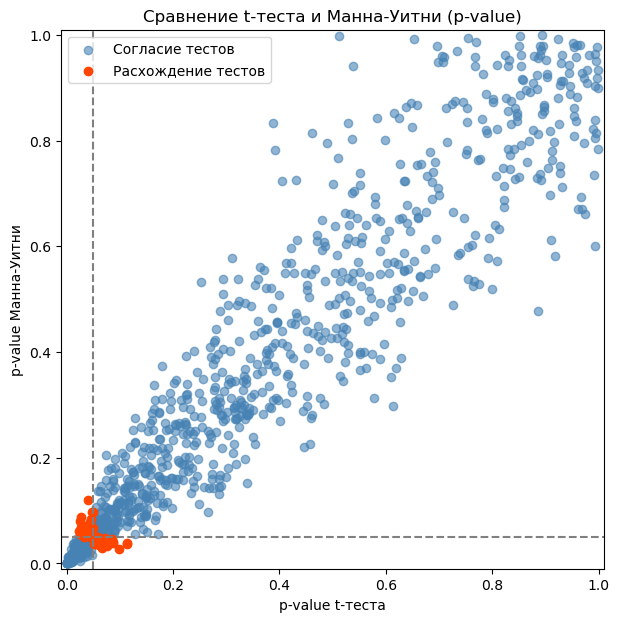

In [38]:
n_sim = 1000  # количество симуляций
nx, ny = 1000, 1000  # размер выборки
mu_x, mu_y = 0, 0.05  # эффект, разница в средних
sigma_x, sigma_y = 1, 1  # стандартное отклонение

pvals_t = []
pvals_mw = []

for _ in range(n_sim):
    x = np.random.normal(mu_x, sigma_x, nx)
    y = np.random.normal(mu_y, sigma_y, ny)
    # t-test (допускаем неравенство дисперсий)
    p_t = stats.ttest_ind(x, y, equal_var=False).pvalue
    p_mw = stats.mannwhitneyu(x, y, alternative='two-sided').pvalue

    pvals_t.append(p_t)
    pvals_mw.append(p_mw)

pvals_t = np.array(pvals_t)
pvals_mw = np.array(pvals_mw)

# Классификация точек
sig_t = pvals_t < 0.05
sig_mw = pvals_mw < 0.05
same = (sig_t == sig_mw)  # оба либо значимы, либо оба незн.
diff = (sig_t != sig_mw)  # расходятся

# РИСУНОК
plt.figure(figsize=(7,7))
plt.scatter(pvals_t[same], pvals_mw[same], color='steelblue', alpha=0.6, label='Cогласие тестов')
plt.scatter(pvals_t[diff], pvals_mw[diff], color='orangered', alpha=1.0, label='Расхождение тестов')
plt.axhline(0.05, color='gray', linestyle='dashed')
plt.axvline(0.05, color='gray', linestyle='dashed')
plt.xlabel('p-value t-теста')
plt.ylabel('p-value Манна-Уитни')
plt.title('Сравнение t-теста и Манна-Уитни (p-value)')
plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.legend()
plt.show()

In [39]:
# Классификация точек
sig_t = pvals_t < 0.05         # t-test значим?
sig_mw = pvals_mw < 0.05       # MW-U значим?

# Каждый тест по отдельности
percent_t = 100 * np.mean(sig_t)
percent_mw = 100 * np.mean(sig_mw)

# Хотя бы один тест значим
sig_either = sig_t | sig_mw    # логическое "или"
percent_either = 100 * np.mean(sig_either)

print(f'Процент значимых для t-теста: {percent_t:.1f}%')
print(f'Процент значимых для Манна-Уитни: {percent_mw:.1f}%')
print(f'Процент, когда хотя бы один тест значим: {percent_either:.1f}%')

Процент значимых для t-теста: 20.9%
Процент значимых для Манна-Уитни: 20.0%
Процент, когда хотя бы один тест значим: 23.4%


## 4.1 Множественное тестирование


<img src="pictures/multi1.png" width="600">

Как растёт вероятность хотя бы одной ложного открытия (“ошибки I рода” или “family-wise error rate”, FWER), если делать много независимых A/B тестов при фиксированном уровне значимости $\alpha$ (например, 0.05).

---

Если вы проверяете $m$ независимых гипотез при фиксированном $\alpha$,
- **Вероятность не допустить ошибку** на каждой гипотезе — $1-\alpha$
- **Вероятность не допустить ошибку ни на одной из $m$**: $(1-\alpha)^m$
- **Вероятность хотя бы одного ложноположительного открытия** (FWER):

$$
P(\text{ошибка хотя бы по одной из } m) = 1 - (1 - \alpha)^m
$$

Чем больше $m$, тем выше FWER, даже при малом $\alpha$!

---



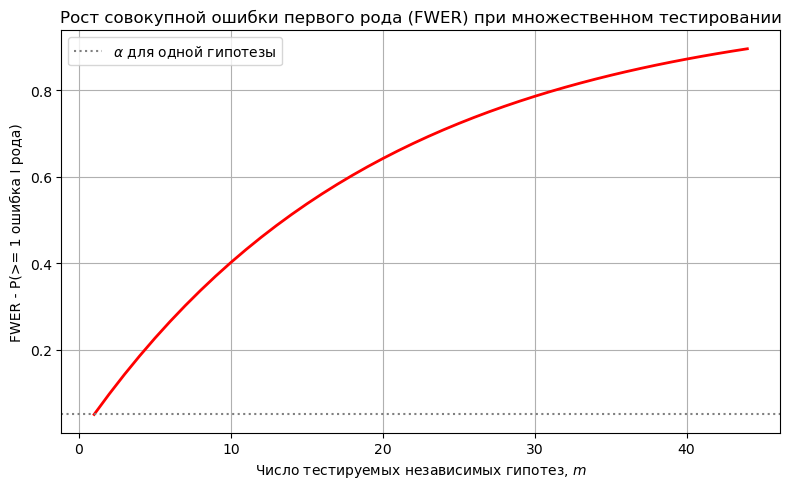

In [40]:
# параметры
alpha = 0.05
m = np.arange(1, 45) 

# FWER график
fwer = 1 - (1 - alpha)**m

# Визуализация
plt.figure(figsize=(8, 5))
plt.plot(m, fwer, lw=2, color='red')
plt.xlabel('Число тестируемых независимых гипотез, $m$')
plt.ylabel('FWER - P(>= 1 ошибка I рода)')
plt.title('Рост совокупной ошибки первого рода (FWER) при множественном тестировании')
plt.axhline(y=alpha, color='gray', linestyle='dotted', label='$\\alpha$ для одной гипотезы')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<img src="pictures/multi2.png" width="600">

<img src="pictures/multi3.png" width="600">

<img src="pictures/multi4.png" width="600">

In [41]:
1 - (1 - alpha)**29

0.7740644590074345

Все усугубляется еще и тем, что метрики сильно скоррелированы, то есть если красится случайно одна, то за ней тянутся и другие.

**Пусть у нас $m$ независимых гипотез, и для каждой тестируемой гипотезы мы используем уровень значимости $\alpha$ (например, $0.05$).  
Нулевая гипотеза верна для всех тестов.**

- Вероятность сработать (обнаружить ошибку I рода) для одной гипотезы = $\alpha$.
- Пусть $X$ — число ложных открытий ('сработавших' гипотез) из $m$ гипотез.

- $X \sim \mathrm{Binomial}(m,\,\alpha)$

**Математическое ожидание:**
$$
E[X] = m \cdot \alpha
$$


In [42]:
50*alpha

2.5

In [43]:
n_groups = 2
n_segments = 29
n_metrics = 100

print(f'FWER = {round(1 - (1 - alpha)**(n_groups + n_segments + n_metrics), 4)}, матожидание числа ложных срабатываний {round(alpha*(n_groups + n_segments + n_metrics), 4)}')

FWER = 0.9988, матожидание числа ложных срабатываний 6.55


<img src="pictures/multi5.png" width="600">

## Familywise error rate и поправки p-values

<img src="pictures/multi6.png" width="600">
<img src="pictures/multi7.png" width="600">
<img src="pictures/multi8.png" width="600">

In [44]:
m = 16
print(f'Bonferroni: {round(alpha/m, 7)}, Šidák: {round(1-(1-alpha)**(1/m), 7)}')

Bonferroni: 0.003125, Šidák: 0.0032007


<img src="pictures/multi9.png" width="600">

In [45]:
from statsmodels.stats.multitest import multipletests


def simulate_multiple_testing(
    m=20,
    n_per_group=50,
    n_exp=2000,
    alpha=0.05,
    n_alt=2,
    effect=0.7,
    seed=42
):
    np.random.seed(seed)
    fwer_uncorr = []
    fwer_bonf = []
    fwer_sidak = []
    fwer_holm = []
    power_uncorr = []
    power_bonf = []
    power_sidak = []
    power_holm = []
    
    for _ in tqdm(range(n_exp)):
        alt_idx = np.random.choice(m, n_alt, replace=False) if n_alt else []
        pvals = []
        for i in range(m):
            mu_control = 0
            mu_test = effect if i in alt_idx else 0
            control = np.random.normal(mu_control, 1, size=n_per_group)
            test = np.random.normal(mu_test, 1, size=n_per_group)
            stat, p = ttest_ind(test, control, equal_var=False)
            pvals.append(p)
        pvals = np.array(pvals)
        
        # Без поправки
        reject_uncorr = pvals < alpha
        # Bonferroni
        reject_bonf, _, _, _ = multipletests(pvals, alpha=alpha, method='bonferroni')
        # Sidak
        reject_sidak, _, _, _ = multipletests(pvals, alpha=alpha, method='sidak')
        # Holm
        reject_holm, _, _, _ = multipletests(pvals, alpha=alpha, method='holm')
        
        # FWER: хотя бы одна ложная находка среди нулевых гипотез
        true_nulls  = np.ones(m, dtype=bool)
        true_nulls[alt_idx] = False
        true_alts = ~true_nulls
        fwer_uncorr.append(np.any(reject_uncorr & true_nulls))
        fwer_bonf.append(np.any(reject_bonf & true_nulls))
        fwer_sidak.append(np.any(reject_sidak & true_nulls))
        fwer_holm.append(np.any(reject_holm & true_nulls))
        # Power: хотя бы одно истинное обнаружение среди альт-гипотез
        power_uncorr.append(np.any(reject_uncorr & true_alts))
        power_bonf.append(np.any(reject_bonf & true_alts))
        power_sidak.append(np.any(reject_sidak & true_alts))
        power_holm.append(np.any(reject_holm & true_alts))
        
    return {
        'fwer_uncorr': np.mean(fwer_uncorr),
        'fwer_bonf': np.mean(fwer_bonf),
        'fwer_sidak': np.mean(fwer_sidak),
        'fwer_holm': np.mean(fwer_holm),
        'power_uncorr': np.mean(power_uncorr),
        'power_bonf': np.mean(power_bonf),
        'power_sidak': np.mean(power_sidak),
        'power_holm': np.mean(power_holm)
    }



100%|██████████| 1000/1000 [02:52<00:00,  5.78it/s]


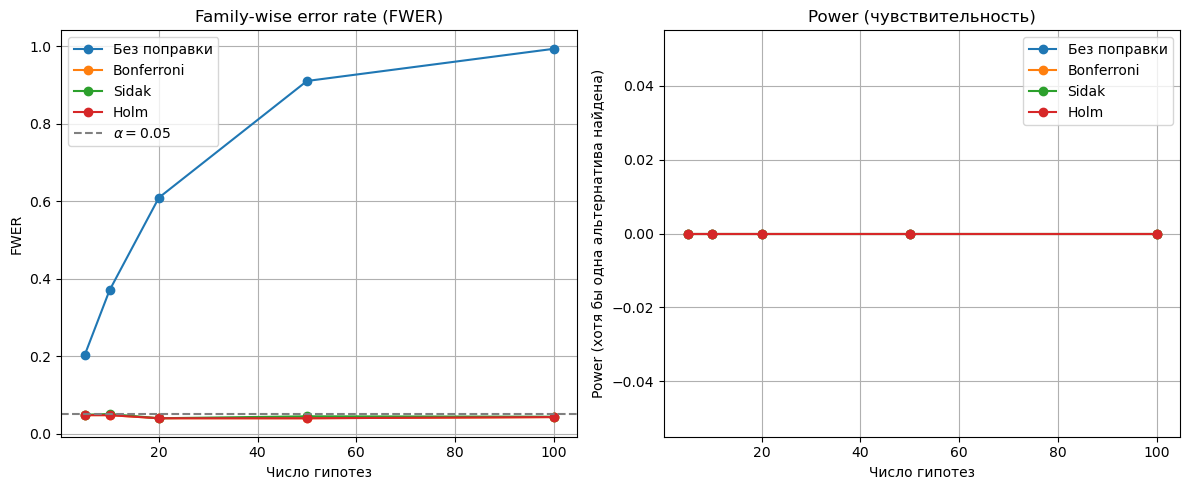

In [46]:

m_list = [5, 10, 20, 50, 100]
fwer_uncorr, fwer_bonf, fwer_sidak, fwer_holm = [], [], [], []
power_uncorr, power_bonf, power_sidak, power_holm = [], [], [], []

for m in m_list:
    res = simulate_multiple_testing(
        m=m, n_per_group=50, n_exp=1000, alpha=0.05,
        n_alt=0, effect=0.7)
    fwer_uncorr.append(res['fwer_uncorr'])
    fwer_bonf.append(res['fwer_bonf'])
    fwer_sidak.append(res['fwer_sidak'])
    fwer_holm.append(res['fwer_holm'])
    power_uncorr.append(res['power_uncorr'])
    power_bonf.append(res['power_bonf'])
    power_sidak.append(res['power_sidak'])
    power_holm.append(res['power_holm'])

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(m_list, fwer_uncorr, 'o-', label='Без поправки')
plt.plot(m_list, fwer_bonf, 'o-', label='Bonferroni')
plt.plot(m_list, fwer_sidak, 'o-', label='Sidak')
plt.plot(m_list, fwer_holm, 'o-', label='Holm')
plt.axhline(0.05, ls='--', color='gray', label='$\\alpha=0.05$')
plt.xlabel("Число гипотез")
plt.ylabel("FWER")
plt.title("Family-wise error rate (FWER)")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(m_list, power_uncorr, 'o-', label='Без поправки')
plt.plot(m_list, power_bonf, 'o-', label='Bonferroni')
plt.plot(m_list, power_sidak, 'o-', label='Sidak')
plt.plot(m_list, power_holm, 'o-', label='Holm')
plt.xlabel("Число гипотез")
plt.ylabel("Power (хотя бы одна альтернатива найдена)")
plt.title("Power (чувствительность)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()




In [47]:
results_dict = {
    'm':           m_list,
    'FWER (uncorr)': fwer_uncorr,
    'FWER (Bonferroni)': fwer_bonf,
    'FWER (Sidak)': fwer_sidak,
    'FWER (Holm)': fwer_holm,
    'Power (uncorr)': power_uncorr,
    'Power (Bonferroni)': power_bonf,
    'Power (Sidak)': power_sidak,
    'Power (Holm)': power_holm,
}
df_results = pd.DataFrame(results_dict)
print(df_results.round(3))

     m  FWER (uncorr)  FWER (Bonferroni)  FWER (Sidak)  FWER (Holm)  \
0    5          0.204              0.048         0.049        0.048   
1   10          0.370              0.048         0.051        0.048   
2   20          0.609              0.040         0.040        0.040   
3   50          0.910              0.040         0.045        0.040   
4  100          0.993              0.043         0.044        0.043   

   Power (uncorr)  Power (Bonferroni)  Power (Sidak)  Power (Holm)  
0             0.0                 0.0            0.0           0.0  
1             0.0                 0.0            0.0           0.0  
2             0.0                 0.0            0.0           0.0  
3             0.0                 0.0            0.0           0.0  
4             0.0                 0.0            0.0           0.0  


100%|██████████| 1000/1000 [02:37<00:00,  6.34it/s]


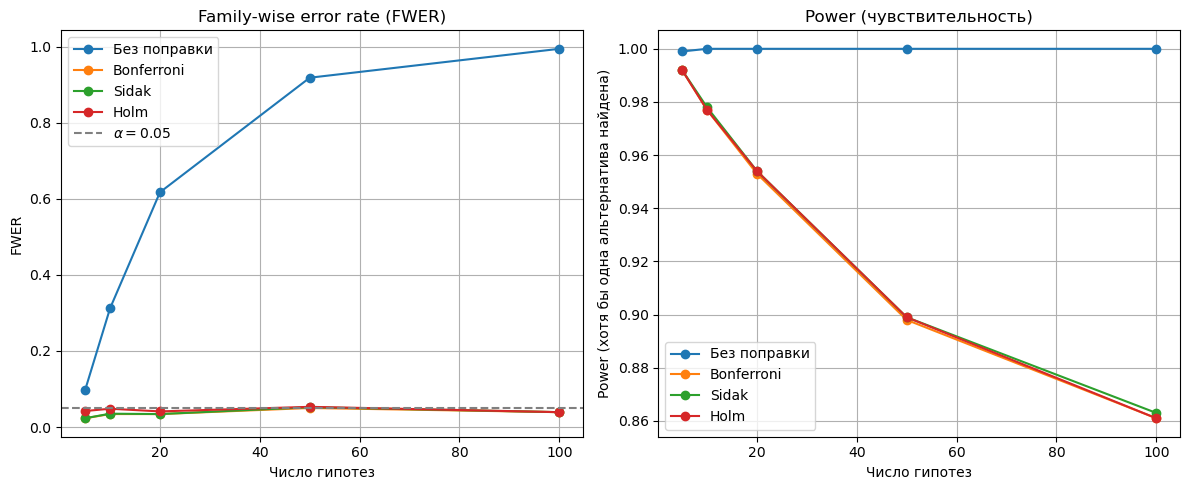

In [48]:
# Пример использования:
m_list = [5, 10, 20, 50, 100]
fwer_uncorr, fwer_bonf, fwer_sidak, fwer_holm = [], [], [], []
power_uncorr, power_bonf, power_sidak, power_holm = [], [], [], []

for m in m_list:
    res = simulate_multiple_testing(
        m=m, n_per_group=50, n_exp=1000, alpha=0.05,
        n_alt=3, effect=0.7)
    fwer_uncorr.append(res['fwer_uncorr'])
    fwer_bonf.append(res['fwer_bonf'])
    fwer_sidak.append(res['fwer_sidak'])
    fwer_holm.append(res['fwer_holm'])
    power_uncorr.append(res['power_uncorr'])
    power_bonf.append(res['power_bonf'])
    power_sidak.append(res['power_sidak'])
    power_holm.append(res['power_holm'])

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(m_list, fwer_uncorr, 'o-', label='Без поправки')
plt.plot(m_list, fwer_bonf, 'o-', label='Bonferroni')
plt.plot(m_list, fwer_sidak, 'o-', label='Sidak')
plt.plot(m_list, fwer_holm, 'o-', label='Holm')
plt.axhline(0.05, ls='--', color='gray', label='$\\alpha=0.05$')
plt.xlabel("Число гипотез")
plt.ylabel("FWER")
plt.title("Family-wise error rate (FWER)")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(m_list, power_uncorr, 'o-', label='Без поправки')
plt.plot(m_list, power_bonf, 'o-', label='Bonferroni')
plt.plot(m_list, power_sidak, 'o-', label='Sidak')
plt.plot(m_list, power_holm, 'o-', label='Holm')
plt.xlabel("Число гипотез")
plt.ylabel("Power (хотя бы одна альтернатива найдена)")
plt.title("Power (чувствительность)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()




In [49]:
results_dict = {
    'm':           m_list,
    'FWER (uncorr)': fwer_uncorr,
    'FWER (Bonferroni)': fwer_bonf,
    'FWER (Sidak)': fwer_sidak,
    'FWER (Holm)': fwer_holm,
    'Power (uncorr)': power_uncorr,
    'Power (Bonferroni)': power_bonf,
    'Power (Sidak)': power_sidak,
    'Power (Holm)': power_holm,
}
df_results = pd.DataFrame(results_dict)
print(df_results.round(3))

     m  FWER (uncorr)  FWER (Bonferroni)  FWER (Sidak)  FWER (Holm)  \
0    5          0.097              0.023         0.023        0.042   
1   10          0.312              0.034         0.035        0.048   
2   20          0.617              0.034         0.034        0.041   
3   50          0.918              0.050         0.052        0.053   
4  100          0.994              0.039         0.039        0.039   

   Power (uncorr)  Power (Bonferroni)  Power (Sidak)  Power (Holm)  
0           0.999               0.992          0.992         0.992  
1           1.000               0.977          0.978         0.977  
2           1.000               0.953          0.954         0.954  
3           1.000               0.898          0.899         0.899  
4           1.000               0.861          0.863         0.861  


<img src="pictures/multi10.png" width="600">

## False discovery rate и поправки p-values

<img src="pictures/multi11.png" width="600">

<img src="pictures/multi12.png" width="600">

<img src="pictures/multi13.png" width="600">

In [50]:
def simulate_multiple_testing_2(
    m=20,
    n_per_group=50,
    n_exp=2000,
    alpha=0.05,
    n_alt=2,
    effect=0.7,
    seed=42
):
    np.random.seed(seed)
    fwer_uncorr = []
    fwer_bonf = []
    fwer_sidak = []
    fwer_holm = []
    fwer_fdr = []
    power_uncorr = []
    power_bonf = []
    power_sidak = []
    power_holm = []
    power_fdr = []
    
    for _ in tqdm(range(n_exp)):
        # randomly choose which hypotheses have effect
        alt_idx = np.random.choice(m, n_alt, replace=False) if n_alt else []
        pvals = []
        for i in range(m):
            mu_control = 0
            mu_test = effect if i in alt_idx else 0
            control = np.random.normal(mu_control, 1, size=n_per_group)
            test = np.random.normal(mu_test, 1, size=n_per_group)
            stat, p = ttest_ind(test, control, equal_var=False)
            pvals.append(p)
        pvals = np.array(pvals)
        
        # Без поправки
        reject_uncorr = pvals < alpha
        # Bonferroni
        reject_bonf, _, _, _ = multipletests(pvals, alpha=alpha, method='bonferroni')
        # Sidak
        reject_sidak, _, _, _ = multipletests(pvals, alpha=alpha, method='sidak')
        # Holm
        reject_holm, _, _, _ = multipletests(pvals, alpha=alpha, method='holm')
        # Benjamini-Hochberg FDR
        reject_fdr, _, _, _ = multipletests(pvals, alpha=alpha, method='fdr_bh')
        
        # FWER: хотя бы одна ложная находка среди нулевых гипотез
        true_nulls  = np.ones(m, dtype=bool)
        true_nulls[alt_idx] = False
        true_alts = ~true_nulls
        fwer_uncorr.append(np.any(reject_uncorr & true_nulls))
        fwer_bonf.append(np.any(reject_bonf & true_nulls))
        fwer_sidak.append(np.any(reject_sidak & true_nulls))
        fwer_holm.append(np.any(reject_holm & true_nulls))
        fwer_fdr.append(np.any(reject_fdr & true_nulls))
        # Power: хотя бы одно истинное обнаружение среди альт-гипотез
        power_uncorr.append(np.any(reject_uncorr & true_alts))
        power_bonf.append(np.any(reject_bonf & true_alts))
        power_sidak.append(np.any(reject_sidak & true_alts))
        power_holm.append(np.any(reject_holm & true_alts))
        power_fdr.append(np.any(reject_fdr & true_alts))
        
    return {
        'fwer_uncorr': np.mean(fwer_uncorr),
        'fwer_bonf': np.mean(fwer_bonf),
        'fwer_sidak': np.mean(fwer_sidak),
        'fwer_holm': np.mean(fwer_holm),
        'fwer_fdr': np.mean(fwer_fdr),
        'power_uncorr': np.mean(power_uncorr),
        'power_bonf': np.mean(power_bonf),
        'power_sidak': np.mean(power_sidak),
        'power_holm': np.mean(power_holm),
        'power_fdr': np.mean(power_fdr)
    }



100%|██████████| 1000/1000 [02:59<00:00,  5.56it/s]


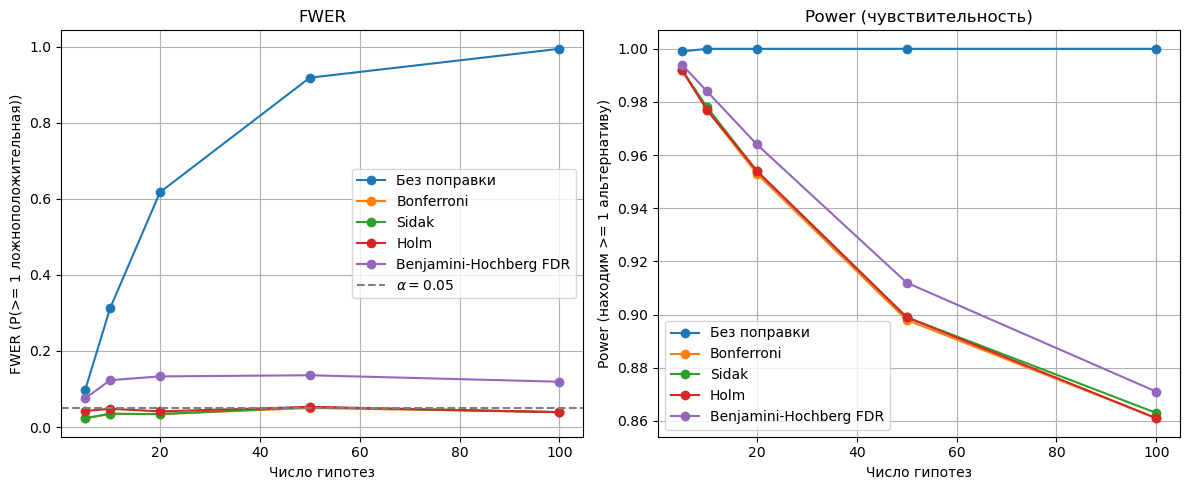

In [51]:

m_list = [5, 10, 20, 50, 100]
fwer_uncorr, fwer_bonf, fwer_sidak, fwer_holm, fwer_fdr = [], [], [], [], []
power_uncorr, power_bonf, power_sidak, power_holm, power_fdr = [], [], [], [], []

for m in m_list:
    res = simulate_multiple_testing_2(
        m=m, n_per_group=50, n_exp=1000, alpha=0.05,
        n_alt=3, effect=0.7)
    fwer_uncorr.append(res['fwer_uncorr'])
    fwer_bonf.append(res['fwer_bonf'])
    fwer_sidak.append(res['fwer_sidak'])
    fwer_holm.append(res['fwer_holm'])
    fwer_fdr.append(res['fwer_fdr'])
    power_uncorr.append(res['power_uncorr'])
    power_bonf.append(res['power_bonf'])
    power_sidak.append(res['power_sidak'])
    power_holm.append(res['power_holm'])
    power_fdr.append(res['power_fdr'])

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(m_list, fwer_uncorr, 'o-', label='Без поправки')
plt.plot(m_list, fwer_bonf, 'o-', label='Bonferroni')
plt.plot(m_list, fwer_sidak, 'o-', label='Sidak')
plt.plot(m_list, fwer_holm, 'o-', label='Holm')
plt.plot(m_list, fwer_fdr, 'o-', label='Benjamini-Hochberg FDR')
plt.axhline(0.05, ls='--', color='gray', label='$\\alpha=0.05$')
plt.xlabel("Число гипотез")
plt.ylabel("FWER (P(>= 1 ложноположительная))")
plt.title("FWER")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(m_list, power_uncorr, 'o-', label='Без поправки')
plt.plot(m_list, power_bonf, 'o-', label='Bonferroni')
plt.plot(m_list, power_sidak, 'o-', label='Sidak')
plt.plot(m_list, power_holm, 'o-', label='Holm')
plt.plot(m_list, power_fdr, 'o-', label='Benjamini-Hochberg FDR')
plt.xlabel("Число гипотез")
plt.ylabel("Power (находим >= 1 альтернативу)")
plt.title("Power (чувствительность)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [52]:
results_dict = {
    'm':           m_list,
    'FWER (uncorr)': fwer_uncorr,
    'FWER (Bonferroni)': fwer_bonf,
    'FWER (Sidak)': fwer_sidak,
    'FWER (Holm)': fwer_holm,
    'FWER (BH FDR)': fwer_fdr
}
df_results = pd.DataFrame(results_dict)
print(df_results.round(3))

     m  FWER (uncorr)  FWER (Bonferroni)  FWER (Sidak)  FWER (Holm)  \
0    5          0.097              0.023         0.023        0.042   
1   10          0.312              0.034         0.035        0.048   
2   20          0.617              0.034         0.034        0.041   
3   50          0.918              0.050         0.052        0.053   
4  100          0.994              0.039         0.039        0.039   

   FWER (BH FDR)  
0          0.075  
1          0.123  
2          0.133  
3          0.136  
4          0.119  


In [53]:
results_dict = {
    'm':           m_list,
    'Power (uncorr)': power_uncorr,
    'Power (Bonferroni)': power_bonf,
    'Power (Sidak)': power_sidak,
    'Power (Holm)': power_holm,
    'Power (BH FDR)': power_fdr
}
df_results = pd.DataFrame(results_dict)
print(df_results.round(3))

     m  Power (uncorr)  Power (Bonferroni)  Power (Sidak)  Power (Holm)  \
0    5           0.999               0.992          0.992         0.992   
1   10           1.000               0.977          0.978         0.977   
2   20           1.000               0.953          0.954         0.954   
3   50           1.000               0.898          0.899         0.899   
4  100           1.000               0.861          0.863         0.861   

   Power (BH FDR)  
0           0.994  
1           0.984  
2           0.964  
3           0.912  
4           0.871  


<img src="pictures/multi14.png" width="600">

## Общий критерий значимого изменения по эксперименту целиком (bootstrap)

<img src="pictures/multi15.png" width="600">

In [54]:
def simulate_global_criterion(
    m_metrics=10,          # число метрик (гипотез)
    n_per_group=50,        # наблюдений на метрику в контроле и тесте
    n_repeat=5000,         # сколько раз делать АА-тест
    alpha=0.05,
    stat_func=np.mean,      # T - функция агрегации p-value (берём минимум)
    seed=42
):
    np.random.seed(seed)
    T_values = []
    for _ in tqdm(range(n_repeat)):
        pvals = []
        for i in range(m_metrics):
            control = np.random.normal(0, 1, size=n_per_group)
            test    = np.random.normal(0, 1, size=n_per_group)
            # true effect = 0!
            stat, p = ttest_ind(test, control, equal_var=False)
            pvals.append(p)                           # двусторонний t-тест
        T_val = stat_func(pvals)                      # T = mean(p_1, ..., p_m)
        T_values.append(T_val)
    # Критическое значение: квантиль (например, 5%)
    threshold = np.quantile(T_values, alpha)
    return T_values, threshold


In [55]:

T_vals, thresh = simulate_global_criterion(
    m_metrics=10, n_per_group=50, n_repeat=10000, alpha=0.05
)

100%|██████████| 10000/10000 [01:51<00:00, 89.66it/s]


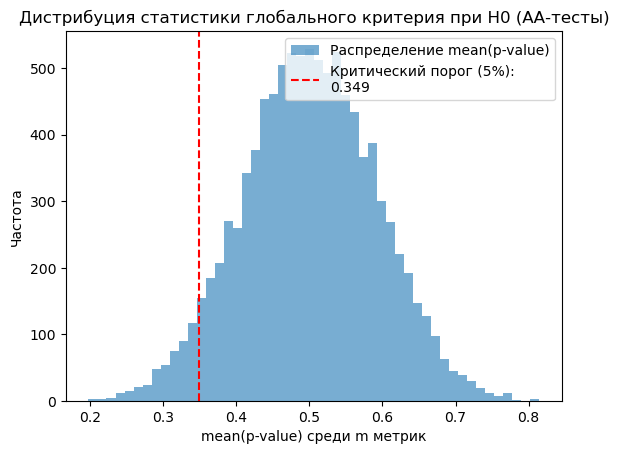

Критический уровень для mean(p-value): 0.349


In [56]:
plt.hist(T_vals, bins=50, alpha=0.6, label='Распределение mean(p-value)')
plt.axvline(thresh, color='red', ls='--', label=f'Критический порог (5%):\n{thresh:.3f}')
plt.xlabel('mean(p-value) среди m метрик')
plt.ylabel('Частота')
plt.title('Дистрибуция статистики глобального критерия при H0 (АА-тесты)')
plt.legend()
plt.show()
print(f'Критический уровень для mean(p-value): {thresh:.3f}')

In [57]:
def get_critical_threshold(
    m_metrics=10, n_per_group=50, n_repeat=5000, alpha=0.05, stat_func=np.min, seed=42
):
    np.random.seed(seed)
    T_values = []
    for _ in tqdm(range(n_repeat)):
        pvals = []
        for i in range(m_metrics):
            control = np.random.normal(0, 1, size=n_per_group)
            test = np.random.normal(0, 1, size=n_per_group)
            stat, p = ttest_ind(test, control, equal_var=False)
            pvals.append(p)
        T_val = stat_func(pvals)
        T_values.append(T_val)
    threshold = np.quantile(T_values, alpha)
    return threshold, T_values

def evaluate_criterion(
    m_metrics=10, n_per_group=50, n_repeat=2000, alpha=0.05, threshold=None,
    stat_func=np.min, n_alt=0, effect=0.5, seed=100
):
    np.random.seed(seed)
    sras = 0
    T_values = []
    for _ in tqdm(range(n_repeat)):
        pvals = []
        for i in range(m_metrics):
            mu_control = 0
            mu_test = effect if (i < n_alt) else 0  # Эффект только для первых n_alt метрик
            control = np.random.normal(mu_control, 1, size=n_per_group)
            test = np.random.normal(mu_test, 1, size=n_per_group)
            stat, p = ttest_ind(test, control, equal_var=False)
            pvals.append(p)
        T_val = stat_func(pvals)
        T_values.append(T_val)
        if T_val < threshold:
            sras += 1
    frac = sras / n_repeat
    return frac, T_values



In [58]:
# Параметры симуляции
m_metrics = 10
n_per_group = 50
alpha = 0.05
n_repeat = 5000
effect = 0.5       # сила эффекта в тесте
n_alt = 2          # сколько метрик с эффектом

# 1. Калибруем критерий (H0, нет эффекта)
threshold, null_dist = get_critical_threshold(
    m_metrics=m_metrics, n_per_group=n_per_group, n_repeat=n_repeat, alpha=alpha, stat_func=np.mean, seed=42
)


# 2. False Positive Rate: Проверим ошибку I рода (должна быть ~= alpha)
fpr, null_vals = evaluate_criterion(
    m_metrics=m_metrics, n_per_group=n_per_group, n_repeat=2000, alpha=alpha, threshold=threshold,
    stat_func=np.mean, n_alt=0, effect=effect, seed=123
)


# 3. Power: Добавим эффект к n_alt метрикам!
power, alt_vals = evaluate_criterion(
    m_metrics=m_metrics, n_per_group=n_per_group, n_repeat=2000, alpha=alpha, threshold=threshold,
    stat_func=np.mean, n_alt=n_alt, effect=effect, seed=987
)


100%|██████████| 2000/2000 [00:22<00:00, 89.97it/s]


Критический порог (mean(p-value)) под H0 (FWER=0.05): 0.3484
FWER без эффекта (false positive rate): 0.052
Power с эффектом (2 метрик по +0.5): 0.220


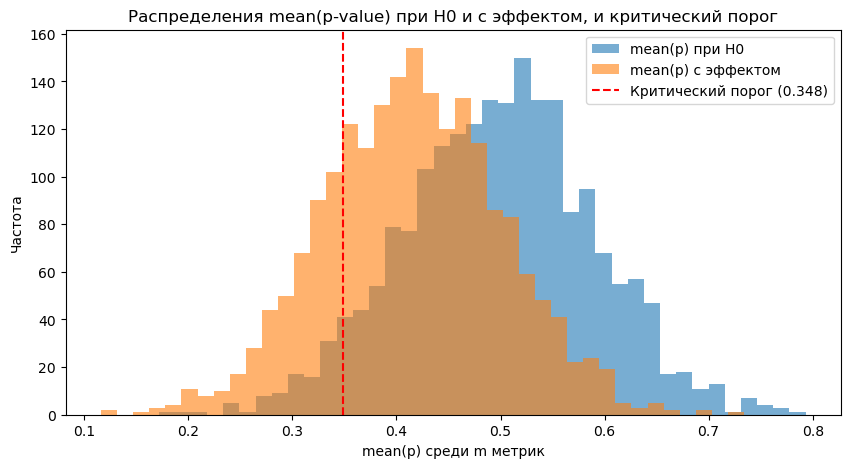

In [59]:
print(f"Критический порог (mean(p-value)) под H0 (FWER={alpha}): {threshold:.4f}")
print(f"FWER без эффекта (false positive rate): {fpr:.3f}")
print(f"Power с эффектом ({n_alt} метрик по {effect:+}): {power:.3f}")

# 4. Визуализация
plt.figure(figsize=(10,5))
plt.hist(null_vals, bins=40, alpha=0.6, label='mean(p) при H0')
plt.hist(alt_vals, bins=40, alpha=0.6, label='mean(p) c эффектом')
plt.axvline(threshold, color='red', ls='--', label=f'Критический порог ({threshold:.3f})')
plt.xlabel("mean(p) среди m метрик")
plt.ylabel("Частота")
plt.legend()
plt.title("Распределения mean(p-value) при H0 и с эффектом, и критический порог")
plt.show()


In [60]:
# Параметры симуляции
m_metrics = 10
n_per_group = 50
alpha = 0.05
n_repeat = 5000
effect = 0.5       # сила эффекта в тесте
n_alt = 2          # сколько метрик с эффектом

# 1. Калибруем критерий (H0, нет эффекта)
threshold, null_dist = get_critical_threshold(
    m_metrics=m_metrics, n_per_group=n_per_group, n_repeat=n_repeat, alpha=alpha, stat_func=np.min, seed=42
)

# 2. False Positive Rate: Проверим ошибку I рода (должна быть ~= alpha)
fpr, null_vals = evaluate_criterion(
    m_metrics=m_metrics, n_per_group=n_per_group, n_repeat=2000, alpha=alpha, threshold=threshold,
    stat_func=np.min, n_alt=0, effect=effect, seed=123
)


# 3. Power: Добавим эффект к n_alt метрикам!
power, alt_vals = evaluate_criterion(
    m_metrics=m_metrics, n_per_group=n_per_group, n_repeat=2000, alpha=alpha, threshold=threshold,
    stat_func=np.min, n_alt=n_alt, effect=effect, seed=987
)


100%|██████████| 2000/2000 [00:21<00:00, 91.52it/s]


Критический порог (min(p-value)) под H0 (FWER=0.05): 0.0057
FWER без эффекта (false positive rate): 0.063
Power с эффектом (2 метрик по +0.5): 0.628


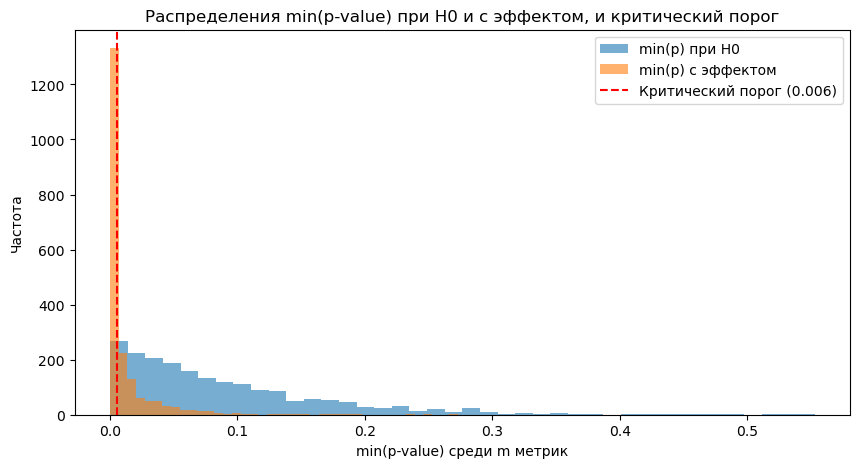

In [61]:
print(f"Критический порог (min(p-value)) под H0 (FWER={alpha}): {threshold:.4f}")
print(f"FWER без эффекта (false positive rate): {fpr:.3f}")
print(f"Power с эффектом ({n_alt} метрик по {effect:+}): {power:.3f}")

# 4. Визуализация
plt.figure(figsize=(10,5))
plt.hist(null_vals, bins=40, alpha=0.6, label='min(p) при H0')
plt.hist(alt_vals, bins=40, alpha=0.6, label='min(p) c эффектом')
plt.axvline(threshold, color='red', ls='--', label=f'Критический порог ({threshold:.3f})')
plt.xlabel("min(p-value) среди m метрик")
plt.ylabel("Частота")
plt.legend()
plt.title("Распределения min(p-value) при H0 и с эффектом, и критический порог")
plt.show()


<img src="pictures/multi16.png" width="800">

## 5. Байес

## 1. **Что делает классический (частотный) A/B тест**
- Мы оцениваем вероятность увидеть наблюдаемые различия между группами, **если** на самом деле никакой разницы нет (p-value).
- Обычно ставим "нулевую гипотезу" (разницы нет), вычисляем p-value, принимаем или отвергаем гипотезу— сравниваем с порогом (0.05 и т.д.).

---

## 2. **Что делает байесовский A/B тест**

**Главная идея:**  
Мы не рассматриваем только одну гипотезу, а работаем с распределением вероятности параметров после учёта новых данных, т.е. **апдейтим наше знание о вероятностях на основе фактических наблюдений**, а не через p-value.

### Как это работает пошагово?

#### 1. **Апостериорное распределение**
- В байесовском подходе мы выражаем свои предположения о параметрах (например, конверсия, средний чек) **через вероятностное распределение**.
- Перед экспериментом у нас есть **априорное распределение** (prior), отражающее наши начальные знания (например, конверсия 5%)
- После получения новых данных (результатов A и B) мы **обновляем** априорное распределение с учётом этих данных — получаем **апостериорное распределение (posterior)**.

$
Posterior = \frac{Likelihood \times Prior}{Evidence}
$

- *Prior* — априорное распределение параметра (например, вероятность того, что конверсия 5%)
- *Likelihood* — правдоподобие данных (например, вероятность наблюдать такие клики, если конверсия 5%)
- *Posterior* — распределение вероятности после учёта ваших данных

#### 2. **Как делается сравнение групп**
- Для каждой из метрик (например, конверсии в A и B) считаем апостериорные распределения.
- Считаем вероятность того, что **метрика в варианте B** больше, чем в варианте A.
- Можно получить не просто “есть статистическая значимость или нет”, а **прямо вероятность улучшения** (например, “вероятность, что B лучше A — 94%”).

---

## 3. **Преимущества байесовского метода**

- **Интерпретируемость:** Вы прямо говорите “с вероятностью X% вариант B лучше варианта A”.
- **Можно делать промежуточные выводы:** Не обязательно ждать конца теста — состояние апостериорного распределения обновляется с каждымдением.
- **Гибкость:** Можно учитывать априорные знания, делать иерархические модели, сравнивать неравные выборки, добавлять сторонние данные.
- **Меньше фиксации на p-value:** Нет жёсткой “черты” типа 0.05, а есть оценка вероятности любого уровня выигрыша.

---

## 4. **Недостатки**

- Требует больше вычислений (но для обычных задач — легко делается).
- Нужно выбрать априорное распределение (но если данных много, результат мало зависит от выбора “prior”).
- Не все к этому привыкли :)

---

**Пример для конверсии**

Пусть у нас 100 пользователей в группе A, из них 8 совершили целевое действие $(x_A = 8, n_A = 100$), и в B — 12 из 100 ($x_B = 12, n_B = 100$).

Для каждой группы считаем:
- prior: например, Beta(1, 1) (равномерно)
- likelihood: биномиальное распределение ($n, x$)
- Получаем posterior: Beta(1+x, 1+n-x)
- Сравниваем постериоры A и B — считаем долю случаев, когда θ_B > θ_A (можно через симуляции).

---

Выбор априорного распределения — ключевой шаг в байесовском анализе

---

### **Основные подходы к выбору prior:**

**a) Нейтральные (неинформативные) априорные**
- **Считаем, что ничего не знаем про параметр до эксперимента.**
- Примеры:
  - **Для вероятности (доля успехов, конверсия):** Beta(1, 1) — равномерное распределение по [0, 1]
  - **Для среднего значения (нормальное распределение):** Normal(0, 1000²) — очень широкий разброс (или вообще flat prior)
- *Обычно используются, чтобы минимально влиять на результат, особенно если данных много.*

---

**b) Информативные априорные**
- **Используем историю/экспертные знания.**
- Примеры:
  - Если в прошлом средняя конверсия была 5% ± 1%, можно использовать Beta(5, 95)
  - Если средний чек был обычно ≈ 1000 ± 200, можно брать Normal(1000, 200²)
- *Позволяет ускорить “сходимость” апостериорного распределения при малых данных.*

---

**c) Полуинформативные априорные**
- **Часто берут не совсем “равномерное”, а умеренно широкое распределение.**
- Например, для пропорции Beta(2, 2) или Beta(0.5, 0.5) — чуть более "размытый" prior, чем Beta(1,1).

---



### **Практические советы**

- **Если данных много (1000+ наблюдений)** — prior очень слабо влияет на ответ: можете брать нейтральный.
- **Если данных мало или тесты часто повторяются с похожими метриками** — используйте историю/экспертную оценку.
- **Лучше недоучесть prior, чем переоценить:** явный информативный prior может “задушить” нетривиальный сигнал в данных.

---

### **Типичные значения для A/B тестов**

- **Конверсия/вероятность события** ($\theta$): Beta(1, 1) или Beta(0.5, 0.5)
- **Ожидаемое число событий**: Gamma(0.01, 0.01) или другое с большим разбросом
- **Среднее (нормально распределённое):** Normal(0, 1000²)  
- **Дисперсия**: Inverse Gamma с маленькими параметрами (широкая)

---


### **NB! Проверяйте чувствительность результата к prior**
- Если есть сомнения, сравните результаты с разными prior — если выводы не меняются, всё ок.
- Если вывод зависит от prior — берите больше данныx, пересмотрите предпосылки или явно сообщайте результат на нескольких prior.

---

Рассмотрим конкретный пример **обновления (апдейта) априорного распределения** с помощью функции правдоподобия в байесовском A/B тесте ― пусть у нас задача двух альтернатив: измеряем конверсию (долю успехов) в группе.

---

0. Исходные данные

Пусть мы хотим оценить вероятность success (например, конверсии на сайте) $\theta$:

- До эксперимента мы считаем, что $\theta$ равновероятно  может принять любое значение на интервале [0,1].  
  Это эквивалентно **априорному Beta(1, 1)** (равномерное распределение).

- В эксперименте мы получили n наблюдений, из них x — success (например, 8 успешных покупок из 100 пользователей).

---

1. **Априорное распределение**

$
\theta \sim \text{Beta}(1, 1)
$

---

2. **Функция правдоподобия (Likelihood)**

Правдоподобие (вероятность увидеть x успехов за n испытаний при вероятности успеха \(\theta\)):

$
L(\theta \mid x, n) = \Pr(\text{x успехов из n} \mid \theta) = \binom{n}{x} \theta^x (1-\theta)^{n-x}
$

---

3. **Обновление по формуле Байеса**

$
\text{Posterior}(\theta \mid x, n) \propto L(\theta \mid x, n) \cdot \text{Prior}(\theta)
$

Если prior — Beta(a, b), функция правдоподобия — биномиальная, то posterior снова будет Beta:

$
\theta \mid x, n \sim \text{Beta}(a + x, \; b + n - x)
$

---

 **Для нашего примера:**

- **Априор:** Beta(1, 1)
- **Данные:** x = 8 success, n = 100

**Апостериор:**

$
\theta \mid x, n \sim \text{Beta}(1 + 8, \; 1 + 100 - 8) = \text{Beta}(9, 93)
$

---

**Что это значит? Какой теперь прогноз вероятности?**

- Математическое ожидание для Beta(9, 93):  
  $
  \mathbb{E}[\theta] = \frac{9}{9 + 93} = \frac{9}{102} \approx 8.8\%
  $
- Форма распределения отражает вашу новую "уверенность" в значении конверсии.

---

### **Общий рабочий шаг (алгоритм):**

1. **Выберите prior** (например, Beta(a, b)).
2. **Посчитайте функцию правдоподобия** (биномиальная, если успех/неудача).
3. **Подсчитайте параметры новой Beta-постериор:**  
   Beta(a + successes, b + failures)
4. **Дальше**: Строите доверительный интервал (credible interval), сравниваете апостериоры групп, делаете выводы.


В **Байесовском A/B-тесте** вероятность того, что метрика в группе B больше, чем в группе A (например, $P(\theta_B > \theta_A)$), считается **прямо, через апостериорные распределения** обеих групп.

---

### **Как это делается:**

1. **Для каждой группы** строятся апостериорные распределения параметров (например, среднего чека, конверсии и т.д.) — обычно через Beta (для доли/конверсии) или Normal (для среднего).

2. **Сэмплируем** большое количество значений из апостериорных распределений $\theta_A$ и $\theta_B$.

3. **Считаем долю сэмплов где $\theta_B > \theta_A$** — это и есть итоговая вероятность превосходства B над A.

---

### **Формула:**
$$
P(\theta_B > \theta_A) \approx \frac{\#\{\theta_B^{(i)} > \theta_A^{(i)}\}}{N}
$$
где $\theta_B^{(i)}, \theta_A^{(i)}$ — независимые сэмплы из апостериорных распределений, $N$ — число сэмплов.

---


In [62]:
# Группа A: 40 успехов из 800, prior Beta(1,1): posterior ~ Beta(41,761)
# Группа B: 50 успехов из 800, prior Beta(1,1): posterior ~ Beta(51,751)
N = 100_000
a_samples = np.random.beta(41, 761, N)
b_samples = np.random.beta(51, 751, N)
prob = np.mean(b_samples > a_samples)
print(f"Вероятность что B > A: {prob:.3f}")

Вероятность что B > A: 0.859


#### Если $F$ – закон с функцией плотности $f(x|\theta) $:

1. Функция правдоподобия ("likelihood"):
Функция правдоподобия — это вероятность (или плотность) получить именно ваши данные из указанного распределения, рассматриваемая как функция параметров $\theta$.

$
L(\theta \mid x_1, \dots, x_n) = \prod_{i=1}^n f(x_i \mid \theta)
$

Где:

$ x_1, \ldots, x_n $ — ваши наблюдаемые данные,

$ f(x_i \mid \theta) $ — плотность вероятности (для непрерывных) или вероятность (для дискретных),  

$ \theta $ — совокупность параметров распределения.

---

2. Логарифм функции правдоподобия (для удобства оптимизации):

$
\ell(\theta \mid x_1, \dots, x_n) = \log L(\theta \mid x_1, ..., x_n) = \sum_{i=1}^n \log f(x_i \mid \theta)
$


---




###  Для нормального prior

- Пусть наблюдения $x_1, x_2, \dots, x_n$ независимы и каждое $x_i \sim \mathcal{N}(\theta, \sigma^2)$, где $\sigma^2$ известно.
- Априорное распределение $\theta$ — нормальное:  
  $\theta \sim \mathcal{N}(\mu_0, \tau_0^2)$

---

1. Функция правдоподобия

$$
L(\theta) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x_i - \theta)^2}{2\sigma^2}\right)
$$

---

2. Правило Байеса

$$
\text{Posterior}(\theta \mid x_{1:n}) \propto L(\theta) \cdot \text{Prior}(\theta)
$$

---

3. В результате апдейт опять даст нормальное распределение!

Формулы для параметров постериорного нормального распределения:

- Дисперсия апостериора:
  
  $$
  \frac{1}{\tau_n^2} = \frac{1}{\tau_0^2} + \frac{n}{\sigma^2}
  $$
  то есть
  $$
  \tau_n^2 = \left( \frac{1}{\tau_0^2} + \frac{n}{\sigma^2} \right)^{-1}
  $$

- Среднее апостериора:
  $$
  \mu_n = \tau_n^2 \left( \frac{\mu_0}{\tau_0^2} + \frac{n\bar{x}}{\sigma^2} \right)
  $$
  где $\bar{x}$ — среднее ваших наблюдений.

Итого:
$$
\boxed{
\theta \mid x_{1:n} \sim \mathcal{N}(\mu_n, \tau_n^2)
}
$$

---


In [63]:

def bayes_prob_B_superior(xA, xB, prior_mu=0, prior_sigma=1000): 
    # a простейший вариант: берем неинформ. нормальный prior, нормальное апостериор, известная дисперсия в группах
    nA, nB = len(xA), len(xB)
    meanA, meanB = np.mean(xA), np.mean(xB)
    varA, varB = np.var(xA, ddof=1), np.var(xB, ddof=1)

    # Posterior параметры
    post_varA = 1 / (1/prior_sigma**2 + nA/varA)
    post_meanA = post_varA * (prior_mu/prior_sigma**2 + nA*meanA/varA)

    post_varB = 1 / (1/prior_sigma**2 + nB/varB)
    post_meanB = post_varB * (prior_mu/prior_sigma**2 + nB*meanB/varB)

    # Разность распределений (разность норма распредел.)
    diff_mean = post_meanB - post_meanA
    diff_std = np.sqrt(post_varA + post_varB)
    # Вероятность P(B > A)
    prob = 1 - stats.norm.cdf(0, loc=diff_mean, scale=diff_std)
    return prob

def simulate_tests(n_sims=1000, n=50, effect=0.0, alpha=0.05, seed=123):
    np.random.seed(seed)
    ttest_signif = 0
    bayes_high = 0
    all_pvals = []
    all_bayesp = []
    for _ in range(n_sims):
        xA = np.random.normal(0, 1, n)
        xB = np.random.normal(effect, 1, n)
        _, p = stats.ttest_ind(xB, xA, equal_var=False)
        bayes_p = bayes_prob_B_superior(xA, xB)
        all_pvals.append(p)
        all_bayesp.append(bayes_p)
        if p < alpha:
            ttest_signif += 1
        if bayes_p > 0.95:
            bayes_high += 1
    return np.array(all_pvals), np.array(all_bayesp), ttest_signif/n_sims, bayes_high/n_sims



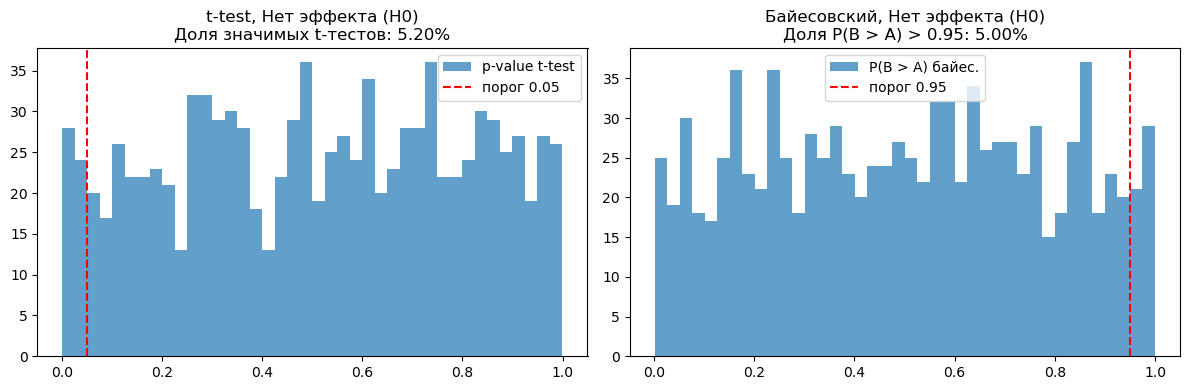

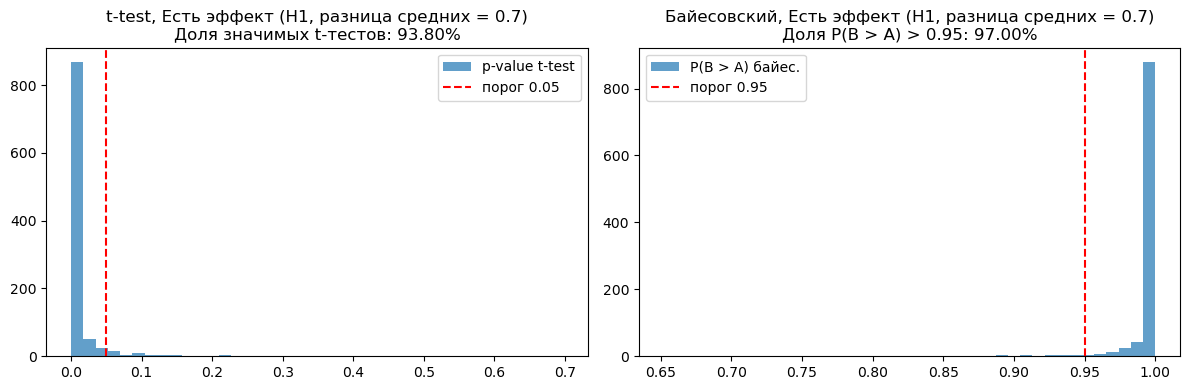

In [64]:
for effect, title in zip([0.0, 0.7], ["Нет эффекта (H0)", "Есть эффект (H1, разница средних = 0.7)"]):
    pvals, bayesp, ttest_rate, bayes_rate = simulate_tests(effect=effect)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.hist(pvals, bins=40, alpha=0.7, label='p-value t-test')
    plt.axvline(0.05, color='red', linestyle='--', label='порог 0.05')
    plt.title(f"t-test, {title}\nДоля значимых t-тестов: {ttest_rate:.2%}")
    plt.legend()
    plt.subplot(1,2,2)
    plt.hist(bayesp, bins=40, alpha=0.7, label='P(B > A) байес.')
    plt.axvline(0.95, color='red', linestyle='--', label='порог 0.95')
    plt.title(f"Байесовский, {title}\nДоля P(B > A) > 0.95: {bayes_rate:.2%}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Соберем все вместе


## 1. **Дизайн эксперимента**

- Нам надо провести АБ тест на определенном сегменте пользователей и мы выбрали ключевую метрику. 

1. Найдем по историческим данным зависимость $\sigma(n)$

2. Определеяем пропорцию $k$ для теста и контроля

3. Какой минимальный эффект мы хотим суметь обнаружить? 

4. Фиксируем ошибки I и II рода

Какой минимальный эффект MDE мы можем задетектировать, если у нас известно  $n, k, \sigma^2$? 

$$e > \sqrt{\dfrac{(z_{1-\alpha/2} + z_{1-\beta})^2 (1 + k)\sigma(m)^2}{m}}$$

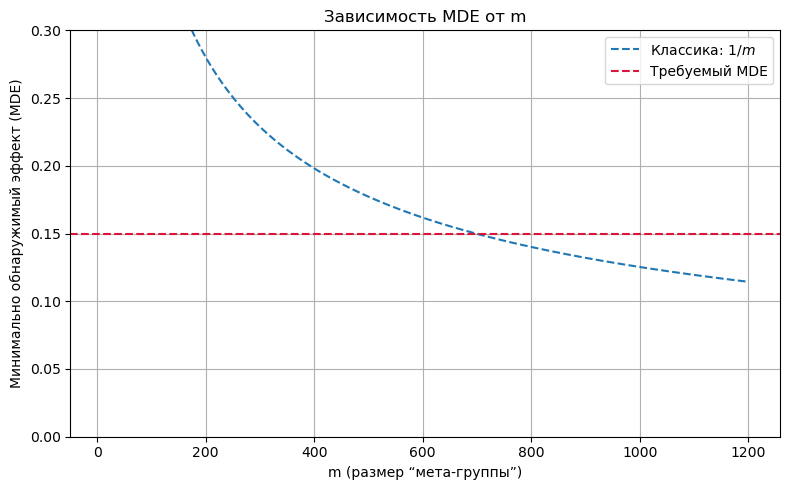

In [65]:
alpha = 0.05
beta = 0.2
k = 1.0
req_mde = 0.15

z_alpha = stats.norm.ppf(1 - alpha/2)
z_beta = stats.norm.ppf(1 - beta)
coef = (z_alpha + z_beta)**2 * (1 + k)


# m от 10 (чтобы не возникало нулей и log(0))
m = np.arange(10, 1200, 1)
mde_classic = [np.sqrt(coef/x) for x in m]

plt.figure(figsize=(8,5))
plt.plot(m, mde_classic, '--', label='Классика: $1/m$')
plt.axhline(req_mde, ls='--', color='crimson', label='Требуемый MDE')

plt.ylim(0, max(0.3, req_mde*2))
plt.xlabel('m (размер “мета-группы”)')
plt.ylabel('Минимально обнаружимый эффект (MDE)')
plt.title('Зависимость MDE от m')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 2. Если тестируем новую модель-критерий

1. Готовим независимые исторические данные-сегменты

2. Изучаем какие процессы происходят в наших данных. Находим приближения в классах определенных распределений (тут нам может помочь тест Колмогорова-Смирнова)

## 3. Если формулируем гипотезу, что выборки пришли из одного распределения

- задаем себе вопрос зачем? 

- если хотим фиксировать структурное изменение пользователей то можно это делать за счет метрик (среднее от средних сравнить с поюзерным средним), персентильных проверок

## 4. Как происходит сплит в эксперименте

In [66]:
import hashlib

def split_by_hash_fun(driver_id, SALT):
    sha1 = hashlib.sha1()
    sha1.update(SALT.encode('utf-8'))
    sha1.update(driver_id.encode('utf-8'))
    res = sha1.hexdigest()[:16]
    return (int(res, 16) % 100) < 50, res, int(res, 16)

In [67]:
driver_id = 'asjhkdglapsdf'

salt_1 = 'super_cool_taxi_icon_in_the_superapp'
salt_2 = 'less_but_still_cool_taxi_icon_in_the_superapp'

In [68]:
split_by_hash_fun(driver_id, salt_1)

(True, 'b3bae1d5122be970', 12950911983706433904)

In [69]:
split_by_hash_fun(driver_id, salt_2)

(True, '53bbb85e0b2ab637', 6033618839846696503)

## 5. Проводим АА тест, если можем

- Идеально, если мы можем провести АА тест, запустить эксперимент на нашем сплите, но без эффекта
- В реальности мы скорее будем делать pre_AA тест, то есть проведем его на исторических данных

## 6. Будем ли подглядывать? 

Используем GST (Group Sequential Test, групповой последовательный тест), с возможностью остановки теста раньше. 

## 7. Собрали данные - считаем результаты

- не забудем про агрегацию 
- проверим выборосы
- CUPED техникой подготовим CUPED-выборки
- Считаем наш критерий 
- Включаем поправки на множественное сравнение